
# Introduction #

Welcome to the [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started) competition! In this competition, you’re challenged to build a machine learning model to classify 104 types of flowers based on their images.

In this tutorial notebook, you'll learn how to build an image classifier in Keras and train it on a [Tensor Processing Unit (TPU)](https://www.kaggle.com/docs/tpu). At the end, you'll have a complete project you can build off of with ideas of your own.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

# Step 1: Imports #

We begin by importing several Python packages.

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

E0000 00:00:1756221379.826302      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Tensorflow version 2.18.0


# Step 2: Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1756221403.364667      74 service.cc:148] XLA service 0x5ae21f0db210 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756221403.364721      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1756221403.364725      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1756221403.364728      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1756221403.364731      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1756221403.364733      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1756221403.364736      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1756221403.364739      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1756221403.364741      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

# Step 3: Loading the Competition Data #

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


/kaggle/input/tpu-getting-started


You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).

## Load Data ##

When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

In [4]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Create Data Pipelines ##

In this final step we'll use the `tf.data` API to define an efficient data pipeline for each of the training, validation, and test splits.

In [5]:

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

In [6]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


These datasets are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. The training and validation sets are streams of `(image, label)` pairs.

In [7]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


Training data label examples: [50 14 75 ... 62 73 28]


The test set is a stream of `(image, idnum)` pairs; `idnum` here is the unique identifier given to the image that we'll use later when we make our submission as a `csv` file.

In [8]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


Test data IDs: ['cc9cd7803' 'e203d6713' '9f6708c0b' ... 'bfcb81efc' 'eea83069a' 'f83e299b4']


# Step 4: Explore Data #

Let's take a moment to look at some of the images in the dataset.

In [9]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.figure(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 20 images.

In [10]:
ds_iter = iter(ds_train.unbatch().batch(20))

Use the Python `next` function to pop out the next batch in the stream and display it with the helper function.

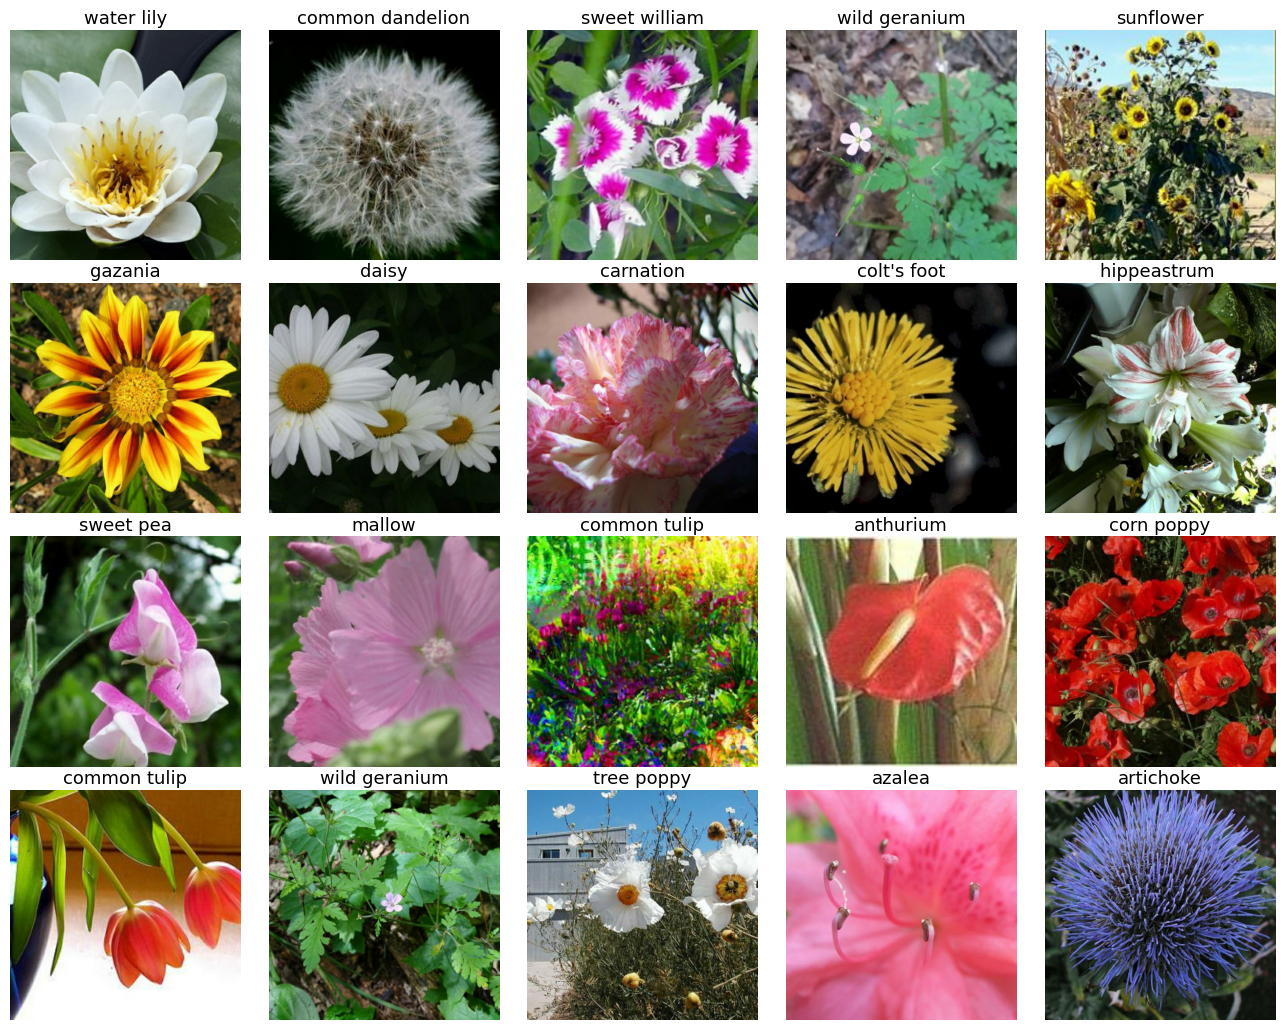

In [11]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

By defining `ds_iter` and `one_batch` in separate cells, you only need to rerun the cell above to see a new batch of images.

# Step 5: Define Model #

Now we're ready to create a neural network for classifying images! We'll use what's known as **transfer learning**. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.

For this tutorial, we'll to use a model called **VGG16** pretrained on [ImageNet](http://image-net.org/)). Later, you might want to experiment with [other models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) included with Keras. ([Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) wouldn't be a bad choice.)

The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context.

In [12]:
EPOCHS = 12

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

I0000 00:00:1756221416.515254      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 6037504/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

17506304/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

30523392/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

44105728/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

57942016/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

In [13]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 16, 16, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │        53,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,768,040 (56.34 MB)

 Trainable params: 53,352 (208.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Step 6: Training #

## Learning Rate Schedule ##

We'll train this network with a special learning rate schedule.

Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


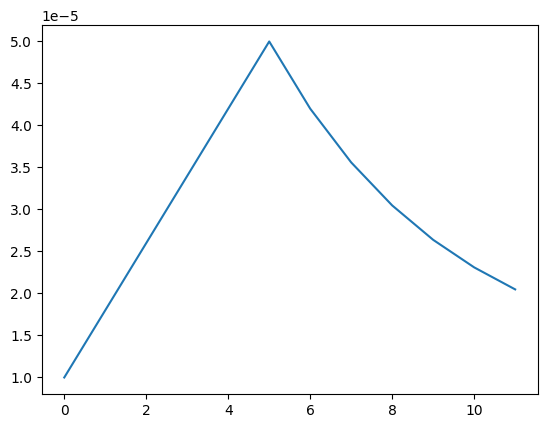

In [14]:

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Fit Model ##

And now we're ready to train the model. After defining a few parameters, we're good to go!

In [15]:
# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    )

    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback],
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.


Epoch 1/12


I0000 00:00:1756221429.360830      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:613711870756993297


I0000 00:00:1756221431.909595     885 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2770145936753229894), session_name()


I0000 00:00:1756221438.399867     885 tpu_compile_op_common.cc:245] Compilation of 2770145936753229894 with session name  took 6.485474571s and succeeded


I0000 00:00:1756221438.405297     885 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2770145936753229894), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_613711870756993297", property.function_library_fingerprint = 18255390119394396689, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,512,512,3,;16,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756221438.405329     885 tpu_compilation_cache_interface.cc:542] After adding entry for key 2770145936753229894 with session_name  cache is 1 entries (13343682 bytes),  marked for eviction 0 entries (0 bytes).


 1/99 ━━━━━━━━━━━━━━━━━━━━ 17:02 10s/step - loss: 4.5006 - sparse_categorical_accuracy: 0.0625

 2/99 ━━━━━━━━━━━━━━━━━━━━ 51s 533ms/step - loss: 4.5666 - sparse_categorical_accuracy: 0.0469

 3/99 ━━━━━━━━━━━━━━━━━━━━ 49s 521ms/step - loss: 4.5888 - sparse_categorical_accuracy: 0.0382

 4/99 ━━━━━━━━━━━━━━━━━━━━ 49s 525ms/step - loss: 4.6029 - sparse_categorical_accuracy: 0.0326

 5/99 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - loss: 4.6001 - sparse_categorical_accuracy: 0.0285

 6/99 ━━━━━━━━━━━━━━━━━━━━ 47s 508ms/step - loss: 4.6005 - sparse_categorical_accuracy: 0.0255

 7/99 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - loss: 4.5994 - sparse_categorical_accuracy: 0.0232

 8/99 ━━━━━━━━━━━━━━━━━━━━ 46s 507ms/step - loss: 4.5972 - sparse_categorical_accuracy: 0.0222

 9/99 ━━━━━━━━━━━━━━━━━━━━ 45s 502ms/step - loss: 4.5957 - sparse_categorical_accuracy: 0.0213

10/99 ━━━━━━━━━━━━━━━━━━━━ 44s 496ms/step - loss: 4.5947 - sparse_categorical_accuracy: 0.0210

11/99 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - loss: 4.5941 - sparse_categorical_accuracy: 0.0207

12/99 ━━━━━━━━━━━━━━━━━━━━ 42s 493ms/step - loss: 4.5925 - sparse_categorical_accuracy: 0.0202

13/99 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - loss: 4.5903 - sparse_categorical_accuracy: 0.0202

14/99 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - loss: 4.5866 - sparse_categorical_accuracy: 0.0203

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - loss: 4.5816 - sparse_categorical_accuracy: 0.0204

16/99 ━━━━━━━━━━━━━━━━━━━━ 40s 491ms/step - loss: 4.5758 - sparse_categorical_accuracy: 0.0203

17/99 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - loss: 4.5706 - sparse_categorical_accuracy: 0.0202

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 492ms/step - loss: 4.5661 - sparse_categorical_accuracy: 0.0200

19/99 ━━━━━━━━━━━━━━━━━━━━ 39s 493ms/step - loss: 4.5611 - sparse_categorical_accuracy: 0.0200

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 493ms/step - loss: 4.5556 - sparse_categorical_accuracy: 0.0201

21/99 ━━━━━━━━━━━━━━━━━━━━ 38s 490ms/step - loss: 4.5500 - sparse_categorical_accuracy: 0.0203

22/99 ━━━━━━━━━━━━━━━━━━━━ 37s 492ms/step - loss: 4.5448 - sparse_categorical_accuracy: 0.0204

23/99 ━━━━━━━━━━━━━━━━━━━━ 37s 492ms/step - loss: 4.5388 - sparse_categorical_accuracy: 0.0207

24/99 ━━━━━━━━━━━━━━━━━━━━ 36s 490ms/step - loss: 4.5338 - sparse_categorical_accuracy: 0.0209

25/99 ━━━━━━━━━━━━━━━━━━━━ 36s 487ms/step - loss: 4.5286 - sparse_categorical_accuracy: 0.0212

26/99 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - loss: 4.5235 - sparse_categorical_accuracy: 0.0215

27/99 ━━━━━━━━━━━━━━━━━━━━ 35s 491ms/step - loss: 4.5184 - sparse_categorical_accuracy: 0.0219

28/99 ━━━━━━━━━━━━━━━━━━━━ 34s 492ms/step - loss: 4.5138 - sparse_categorical_accuracy: 0.0222

29/99 ━━━━━━━━━━━━━━━━━━━━ 34s 490ms/step - loss: 4.5092 - sparse_categorical_accuracy: 0.0225

30/99 ━━━━━━━━━━━━━━━━━━━━ 33s 487ms/step - loss: 4.5047 - sparse_categorical_accuracy: 0.0229

31/99 ━━━━━━━━━━━━━━━━━━━━ 33s 489ms/step - loss: 4.5003 - sparse_categorical_accuracy: 0.0232

32/99 ━━━━━━━━━━━━━━━━━━━━ 32s 488ms/step - loss: 4.4957 - sparse_categorical_accuracy: 0.0238

33/99 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - loss: 4.4912 - sparse_categorical_accuracy: 0.0244

34/99 ━━━━━━━━━━━━━━━━━━━━ 31s 485ms/step - loss: 4.4865 - sparse_categorical_accuracy: 0.0251

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - loss: 4.4818 - sparse_categorical_accuracy: 0.0256

36/99 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - loss: 4.4769 - sparse_categorical_accuracy: 0.0263

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 483ms/step - loss: 4.4723 - sparse_categorical_accuracy: 0.0270

38/99 ━━━━━━━━━━━━━━━━━━━━ 29s 483ms/step - loss: 4.4678 - sparse_categorical_accuracy: 0.0277

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - loss: 4.4636 - sparse_categorical_accuracy: 0.0283

40/99 ━━━━━━━━━━━━━━━━━━━━ 28s 481ms/step - loss: 4.4593 - sparse_categorical_accuracy: 0.0290

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 480ms/step - loss: 4.4551 - sparse_categorical_accuracy: 0.0297

42/99 ━━━━━━━━━━━━━━━━━━━━ 27s 481ms/step - loss: 4.4510 - sparse_categorical_accuracy: 0.0303

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 480ms/step - loss: 4.4468 - sparse_categorical_accuracy: 0.0309

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 480ms/step - loss: 4.4425 - sparse_categorical_accuracy: 0.0314

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 480ms/step - loss: 4.4384 - sparse_categorical_accuracy: 0.0320

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - loss: 4.4342 - sparse_categorical_accuracy: 0.0325

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - loss: 4.4301 - sparse_categorical_accuracy: 0.0331

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 479ms/step - loss: 4.4261 - sparse_categorical_accuracy: 0.0336

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 479ms/step - loss: 4.4220 - sparse_categorical_accuracy: 0.0342

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 479ms/step - loss: 4.4180 - sparse_categorical_accuracy: 0.0347

51/99 ━━━━━━━━━━━━━━━━━━━━ 23s 480ms/step - loss: 4.4142 - sparse_categorical_accuracy: 0.0353

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - loss: 4.4105 - sparse_categorical_accuracy: 0.0358

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 4.4068 - sparse_categorical_accuracy: 0.0362

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 4.4034 - sparse_categorical_accuracy: 0.0367

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 4.4000 - sparse_categorical_accuracy: 0.0371

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 4.3968 - sparse_categorical_accuracy: 0.0376

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 4.3935 - sparse_categorical_accuracy: 0.0380

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - loss: 4.3902 - sparse_categorical_accuracy: 0.0385

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - loss: 4.3870 - sparse_categorical_accuracy: 0.0389

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - loss: 4.3837 - sparse_categorical_accuracy: 0.0393

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 477ms/step - loss: 4.3805 - sparse_categorical_accuracy: 0.0397

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - loss: 4.3773 - sparse_categorical_accuracy: 0.0401

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - loss: 4.3741 - sparse_categorical_accuracy: 0.0405

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - loss: 4.3710 - sparse_categorical_accuracy: 0.0409

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - loss: 4.3680 - sparse_categorical_accuracy: 0.0413

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 4.3651 - sparse_categorical_accuracy: 0.0416

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 4.3623 - sparse_categorical_accuracy: 0.0420

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - loss: 4.3596 - sparse_categorical_accuracy: 0.0423

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - loss: 4.3570 - sparse_categorical_accuracy: 0.0427

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 4.3544 - sparse_categorical_accuracy: 0.0430

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 4.3518 - sparse_categorical_accuracy: 0.0434

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - loss: 4.3493 - sparse_categorical_accuracy: 0.0437

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - loss: 4.3467 - sparse_categorical_accuracy: 0.0441

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - loss: 4.3442 - sparse_categorical_accuracy: 0.0445

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - loss: 4.3416 - sparse_categorical_accuracy: 0.0448

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - loss: 4.3391 - sparse_categorical_accuracy: 0.0452

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - loss: 4.3366 - sparse_categorical_accuracy: 0.0456

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 4.3341 - sparse_categorical_accuracy: 0.0459 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 4.3317 - sparse_categorical_accuracy: 0.0463

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 4.3293 - sparse_categorical_accuracy: 0.0466

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 4.3269 - sparse_categorical_accuracy: 0.0470

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 4.3246 - sparse_categorical_accuracy: 0.0473

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 4.3222 - sparse_categorical_accuracy: 0.0477

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - loss: 4.3199 - sparse_categorical_accuracy: 0.0480

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - loss: 4.3176 - sparse_categorical_accuracy: 0.0484

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - loss: 4.3153 - sparse_categorical_accuracy: 0.0487

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 4.3131 - sparse_categorical_accuracy: 0.0490

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 4.3109 - sparse_categorical_accuracy: 0.0494

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - loss: 4.3087 - sparse_categorical_accuracy: 0.0497

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - loss: 4.3066 - sparse_categorical_accuracy: 0.0500

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 4.3045 - sparse_categorical_accuracy: 0.0504

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 4.3023 - sparse_categorical_accuracy: 0.0507

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 4.3002 - sparse_categorical_accuracy: 0.0510

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 4.2981 - sparse_categorical_accuracy: 0.0514

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - loss: 4.2960 - sparse_categorical_accuracy: 0.0517

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 4.2939 - sparse_categorical_accuracy: 0.0520

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 4.2918 - sparse_categorical_accuracy: 0.0524

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 4.2897 - sparse_categorical_accuracy: 0.0527

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 4.2877 - sparse_categorical_accuracy: 0.0530

I0000 00:00:1756221490.615362      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1802887319151844451


I0000 00:00:1756221491.682104     832 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14024210057200272656), session_name()


I0000 00:00:1756221498.021834     832 tpu_compile_op_common.cc:245] Compilation of 14024210057200272656 with session name  took 6.339677798s and succeeded


I0000 00:00:1756221498.025587     832 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14024210057200272656), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_1802887319151844451", property.function_library_fingerprint = 18304719935853957460, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,512,512,3,;16,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")


I0000 00:00:1756221498.025614     832 tpu_compilation_cache_interface.cc:542] After adding entry for key 14024210057200272656 with session_name  cache is 2 entries (25610169 bytes),  marked for eviction 0 entries (0 bytes).


/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 81s 725ms/step - loss: 4.2861 - sparse_categorical_accuracy: 0.0533 - val_loss: 3.8934 - val_sparse_categorical_accuracy: 0.1320 - learning_rate: 0.0010



Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.


Epoch 2/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - loss: 3.5750 - sparse_categorical_accuracy: 0.1250

 2/99 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - loss: 3.6301 - sparse_categorical_accuracy: 0.1094

 3/99 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - loss: 3.6554 - sparse_categorical_accuracy: 0.1146

 4/99 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - loss: 3.6864 - sparse_categorical_accuracy: 0.1133

 5/99 ━━━━━━━━━━━━━━━━━━━━ 45s 480ms/step - loss: 3.7089 - sparse_categorical_accuracy: 0.1181

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 493ms/step - loss: 3.7278 - sparse_categorical_accuracy: 0.1175

 7/99 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - loss: 3.7445 - sparse_categorical_accuracy: 0.1161

 8/99 ━━━━━━━━━━━━━━━━━━━━ 44s 493ms/step - loss: 3.7578 - sparse_categorical_accuracy: 0.1152

 9/99 ━━━━━━━━━━━━━━━━━━━━ 43s 486ms/step - loss: 3.7639 - sparse_categorical_accuracy: 0.1155

10/99 ━━━━━━━━━━━━━━━━━━━━ 42s 481ms/step - loss: 3.7676 - sparse_categorical_accuracy: 0.1159

11/99 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - loss: 3.7724 - sparse_categorical_accuracy: 0.1151

12/99 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - loss: 3.7784 - sparse_categorical_accuracy: 0.1138

13/99 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - loss: 3.7851 - sparse_categorical_accuracy: 0.1121

14/99 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - loss: 3.7895 - sparse_categorical_accuracy: 0.1108

15/99 ━━━━━━━━━━━━━━━━━━━━ 39s 476ms/step - loss: 3.7952 - sparse_categorical_accuracy: 0.1095

16/99 ━━━━━━━━━━━━━━━━━━━━ 39s 473ms/step - loss: 3.7994 - sparse_categorical_accuracy: 0.1090

17/99 ━━━━━━━━━━━━━━━━━━━━ 38s 470ms/step - loss: 3.8018 - sparse_categorical_accuracy: 0.1093

18/99 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - loss: 3.8039 - sparse_categorical_accuracy: 0.1100

19/99 ━━━━━━━━━━━━━━━━━━━━ 37s 471ms/step - loss: 3.8068 - sparse_categorical_accuracy: 0.1102

20/99 ━━━━━━━━━━━━━━━━━━━━ 37s 470ms/step - loss: 3.8106 - sparse_categorical_accuracy: 0.1105

21/99 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - loss: 3.8138 - sparse_categorical_accuracy: 0.1108

22/99 ━━━━━━━━━━━━━━━━━━━━ 36s 470ms/step - loss: 3.8171 - sparse_categorical_accuracy: 0.1110

23/99 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - loss: 3.8205 - sparse_categorical_accuracy: 0.1113

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - loss: 3.8239 - sparse_categorical_accuracy: 0.1114

25/99 ━━━━━━━━━━━━━━━━━━━━ 34s 467ms/step - loss: 3.8269 - sparse_categorical_accuracy: 0.1115

26/99 ━━━━━━━━━━━━━━━━━━━━ 33s 465ms/step - loss: 3.8295 - sparse_categorical_accuracy: 0.1115

27/99 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 3.8315 - sparse_categorical_accuracy: 0.1115

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 465ms/step - loss: 3.8328 - sparse_categorical_accuracy: 0.1117

29/99 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - loss: 3.8336 - sparse_categorical_accuracy: 0.1123

30/99 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - loss: 3.8344 - sparse_categorical_accuracy: 0.1128

31/99 ━━━━━━━━━━━━━━━━━━━━ 31s 461ms/step - loss: 3.8355 - sparse_categorical_accuracy: 0.1134

32/99 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - loss: 3.8364 - sparse_categorical_accuracy: 0.1140

33/99 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - loss: 3.8376 - sparse_categorical_accuracy: 0.1145

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - loss: 3.8384 - sparse_categorical_accuracy: 0.1149

35/99 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - loss: 3.8391 - sparse_categorical_accuracy: 0.1154

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 464ms/step - loss: 3.8400 - sparse_categorical_accuracy: 0.1159

37/99 ━━━━━━━━━━━━━━━━━━━━ 28s 463ms/step - loss: 3.8409 - sparse_categorical_accuracy: 0.1164

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 463ms/step - loss: 3.8416 - sparse_categorical_accuracy: 0.1168

39/99 ━━━━━━━━━━━━━━━━━━━━ 27s 463ms/step - loss: 3.8424 - sparse_categorical_accuracy: 0.1172

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 463ms/step - loss: 3.8430 - sparse_categorical_accuracy: 0.1175

41/99 ━━━━━━━━━━━━━━━━━━━━ 26s 464ms/step - loss: 3.8437 - sparse_categorical_accuracy: 0.1178

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 3.8441 - sparse_categorical_accuracy: 0.1182

43/99 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - loss: 3.8442 - sparse_categorical_accuracy: 0.1186

44/99 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - loss: 3.8441 - sparse_categorical_accuracy: 0.1190

45/99 ━━━━━━━━━━━━━━━━━━━━ 24s 463ms/step - loss: 3.8439 - sparse_categorical_accuracy: 0.1195

46/99 ━━━━━━━━━━━━━━━━━━━━ 24s 463ms/step - loss: 3.8439 - sparse_categorical_accuracy: 0.1199

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 462ms/step - loss: 3.8438 - sparse_categorical_accuracy: 0.1203

48/99 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step - loss: 3.8437 - sparse_categorical_accuracy: 0.1207

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - loss: 3.8437 - sparse_categorical_accuracy: 0.1211

50/99 ━━━━━━━━━━━━━━━━━━━━ 22s 462ms/step - loss: 3.8437 - sparse_categorical_accuracy: 0.1215

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - loss: 3.8436 - sparse_categorical_accuracy: 0.1218

52/99 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - loss: 3.8435 - sparse_categorical_accuracy: 0.1222

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - loss: 3.8433 - sparse_categorical_accuracy: 0.1226

54/99 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - loss: 3.8432 - sparse_categorical_accuracy: 0.1230

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - loss: 3.8430 - sparse_categorical_accuracy: 0.1234

56/99 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step - loss: 3.8428 - sparse_categorical_accuracy: 0.1237

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - loss: 3.8426 - sparse_categorical_accuracy: 0.1241

58/99 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - loss: 3.8425 - sparse_categorical_accuracy: 0.1243

59/99 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - loss: 3.8424 - sparse_categorical_accuracy: 0.1246

60/99 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - loss: 3.8423 - sparse_categorical_accuracy: 0.1249

61/99 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - loss: 3.8422 - sparse_categorical_accuracy: 0.1252

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - loss: 3.8420 - sparse_categorical_accuracy: 0.1254

63/99 ━━━━━━━━━━━━━━━━━━━━ 16s 461ms/step - loss: 3.8417 - sparse_categorical_accuracy: 0.1257

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 461ms/step - loss: 3.8415 - sparse_categorical_accuracy: 0.1260

65/99 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - loss: 3.8413 - sparse_categorical_accuracy: 0.1262

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - loss: 3.8412 - sparse_categorical_accuracy: 0.1264

67/99 ━━━━━━━━━━━━━━━━━━━━ 14s 461ms/step - loss: 3.8410 - sparse_categorical_accuracy: 0.1266

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 461ms/step - loss: 3.8408 - sparse_categorical_accuracy: 0.1268

69/99 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - loss: 3.8405 - sparse_categorical_accuracy: 0.1270

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - loss: 3.8402 - sparse_categorical_accuracy: 0.1273

71/99 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - loss: 3.8398 - sparse_categorical_accuracy: 0.1275

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - loss: 3.8394 - sparse_categorical_accuracy: 0.1278

73/99 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - loss: 3.8390 - sparse_categorical_accuracy: 0.1281

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - loss: 3.8386 - sparse_categorical_accuracy: 0.1283

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - loss: 3.8381 - sparse_categorical_accuracy: 0.1285

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - loss: 3.8377 - sparse_categorical_accuracy: 0.1288

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - loss: 3.8372 - sparse_categorical_accuracy: 0.1290

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - loss: 3.8368 - sparse_categorical_accuracy: 0.1293 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - loss: 3.8364 - sparse_categorical_accuracy: 0.1295

80/99 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - loss: 3.8359 - sparse_categorical_accuracy: 0.1297

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - loss: 3.8354 - sparse_categorical_accuracy: 0.1300

82/99 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - loss: 3.8348 - sparse_categorical_accuracy: 0.1302

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - loss: 3.8343 - sparse_categorical_accuracy: 0.1305

84/99 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step - loss: 3.8337 - sparse_categorical_accuracy: 0.1307

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step - loss: 3.8331 - sparse_categorical_accuracy: 0.1310

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step - loss: 3.8325 - sparse_categorical_accuracy: 0.1312

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - loss: 3.8319 - sparse_categorical_accuracy: 0.1314

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - loss: 3.8313 - sparse_categorical_accuracy: 0.1317

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - loss: 3.8306 - sparse_categorical_accuracy: 0.1319

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - loss: 3.8300 - sparse_categorical_accuracy: 0.1321

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - loss: 3.8294 - sparse_categorical_accuracy: 0.1323

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - loss: 3.8289 - sparse_categorical_accuracy: 0.1325

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 3.8284 - sparse_categorical_accuracy: 0.1327

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 3.8280 - sparse_categorical_accuracy: 0.1329

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - loss: 3.8275 - sparse_categorical_accuracy: 0.1331

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - loss: 3.8269 - sparse_categorical_accuracy: 0.1333

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 3.8263 - sparse_categorical_accuracy: 0.1335

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 3.8257 - sparse_categorical_accuracy: 0.1338

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 3.8251 - sparse_categorical_accuracy: 0.1340

99/99 ━━━━━━━━━━━━━━━━━━━━ 60s 611ms/step - loss: 3.8247 - sparse_categorical_accuracy: 0.1342 - val_loss: 3.6878 - val_sparse_categorical_accuracy: 0.1843 - learning_rate: 8.1000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.


Epoch 3/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - loss: 3.7547 - sparse_categorical_accuracy: 0.3125

 2/99 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - loss: 3.7618 - sparse_categorical_accuracy: 0.2344

 3/99 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - loss: 3.7811 - sparse_categorical_accuracy: 0.2118

 4/99 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - loss: 3.7628 - sparse_categorical_accuracy: 0.2135

 5/99 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - loss: 3.7580 - sparse_categorical_accuracy: 0.2133

 6/99 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - loss: 3.7565 - sparse_categorical_accuracy: 0.2142

 7/99 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - loss: 3.7558 - sparse_categorical_accuracy: 0.2155

 8/99 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - loss: 3.7571 - sparse_categorical_accuracy: 0.2159

 9/99 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - loss: 3.7540 - sparse_categorical_accuracy: 0.2151

10/99 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - loss: 3.7461 - sparse_categorical_accuracy: 0.2167

11/99 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - loss: 3.7399 - sparse_categorical_accuracy: 0.2177

12/99 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - loss: 3.7337 - sparse_categorical_accuracy: 0.2182

13/99 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - loss: 3.7297 - sparse_categorical_accuracy: 0.2192

14/99 ━━━━━━━━━━━━━━━━━━━━ 39s 464ms/step - loss: 3.7283 - sparse_categorical_accuracy: 0.2194

15/99 ━━━━━━━━━━━━━━━━━━━━ 38s 463ms/step - loss: 3.7257 - sparse_categorical_accuracy: 0.2198

16/99 ━━━━━━━━━━━━━━━━━━━━ 38s 463ms/step - loss: 3.7265 - sparse_categorical_accuracy: 0.2195

17/99 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - loss: 3.7254 - sparse_categorical_accuracy: 0.2200

18/99 ━━━━━━━━━━━━━━━━━━━━ 37s 459ms/step - loss: 3.7252 - sparse_categorical_accuracy: 0.2201

19/99 ━━━━━━━━━━━━━━━━━━━━ 36s 459ms/step - loss: 3.7250 - sparse_categorical_accuracy: 0.2203

20/99 ━━━━━━━━━━━━━━━━━━━━ 36s 462ms/step - loss: 3.7243 - sparse_categorical_accuracy: 0.2204

21/99 ━━━━━━━━━━━━━━━━━━━━ 36s 464ms/step - loss: 3.7233 - sparse_categorical_accuracy: 0.2204

22/99 ━━━━━━━━━━━━━━━━━━━━ 35s 466ms/step - loss: 3.7220 - sparse_categorical_accuracy: 0.2203

23/99 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - loss: 3.7220 - sparse_categorical_accuracy: 0.2201

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - loss: 3.7222 - sparse_categorical_accuracy: 0.2195

25/99 ━━━━━━━━━━━━━━━━━━━━ 34s 467ms/step - loss: 3.7229 - sparse_categorical_accuracy: 0.2188

26/99 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 3.7238 - sparse_categorical_accuracy: 0.2181

27/99 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 3.7247 - sparse_categorical_accuracy: 0.2174

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 468ms/step - loss: 3.7253 - sparse_categorical_accuracy: 0.2170

29/99 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - loss: 3.7263 - sparse_categorical_accuracy: 0.2166

30/99 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - loss: 3.7270 - sparse_categorical_accuracy: 0.2160

31/99 ━━━━━━━━━━━━━━━━━━━━ 31s 465ms/step - loss: 3.7274 - sparse_categorical_accuracy: 0.2154

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - loss: 3.7275 - sparse_categorical_accuracy: 0.2150

33/99 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - loss: 3.7275 - sparse_categorical_accuracy: 0.2145

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - loss: 3.7271 - sparse_categorical_accuracy: 0.2141

35/99 ━━━━━━━━━━━━━━━━━━━━ 29s 467ms/step - loss: 3.7269 - sparse_categorical_accuracy: 0.2137

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - loss: 3.7264 - sparse_categorical_accuracy: 0.2135

37/99 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - loss: 3.7261 - sparse_categorical_accuracy: 0.2133

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 466ms/step - loss: 3.7260 - sparse_categorical_accuracy: 0.2130

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 468ms/step - loss: 3.7259 - sparse_categorical_accuracy: 0.2126

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step - loss: 3.7254 - sparse_categorical_accuracy: 0.2123

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 3.7249 - sparse_categorical_accuracy: 0.2120

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 468ms/step - loss: 3.7244 - sparse_categorical_accuracy: 0.2118

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - loss: 3.7240 - sparse_categorical_accuracy: 0.2114

44/99 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - loss: 3.7236 - sparse_categorical_accuracy: 0.2111

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - loss: 3.7234 - sparse_categorical_accuracy: 0.2108

46/99 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - loss: 3.7234 - sparse_categorical_accuracy: 0.2104

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - loss: 3.7234 - sparse_categorical_accuracy: 0.2100

48/99 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - loss: 3.7232 - sparse_categorical_accuracy: 0.2096

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 3.7230 - sparse_categorical_accuracy: 0.2093

50/99 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - loss: 3.7228 - sparse_categorical_accuracy: 0.2091

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - loss: 3.7226 - sparse_categorical_accuracy: 0.2088

52/99 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - loss: 3.7225 - sparse_categorical_accuracy: 0.2084

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - loss: 3.7221 - sparse_categorical_accuracy: 0.2082

54/99 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - loss: 3.7219 - sparse_categorical_accuracy: 0.2079

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - loss: 3.7217 - sparse_categorical_accuracy: 0.2076

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - loss: 3.7214 - sparse_categorical_accuracy: 0.2073

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - loss: 3.7211 - sparse_categorical_accuracy: 0.2071

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - loss: 3.7207 - sparse_categorical_accuracy: 0.2069

59/99 ━━━━━━━━━━━━━━━━━━━━ 18s 467ms/step - loss: 3.7203 - sparse_categorical_accuracy: 0.2067

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - loss: 3.7198 - sparse_categorical_accuracy: 0.2066

61/99 ━━━━━━━━━━━━━━━━━━━━ 17s 470ms/step - loss: 3.7195 - sparse_categorical_accuracy: 0.2064

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - loss: 3.7191 - sparse_categorical_accuracy: 0.2062

63/99 ━━━━━━━━━━━━━━━━━━━━ 16s 470ms/step - loss: 3.7187 - sparse_categorical_accuracy: 0.2060

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - loss: 3.7183 - sparse_categorical_accuracy: 0.2058

65/99 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - loss: 3.7179 - sparse_categorical_accuracy: 0.2056

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - loss: 3.7176 - sparse_categorical_accuracy: 0.2054

67/99 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - loss: 3.7173 - sparse_categorical_accuracy: 0.2051

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - loss: 3.7170 - sparse_categorical_accuracy: 0.2049

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - loss: 3.7167 - sparse_categorical_accuracy: 0.2047

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - loss: 3.7163 - sparse_categorical_accuracy: 0.2045

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step - loss: 3.7160 - sparse_categorical_accuracy: 0.2043

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - loss: 3.7156 - sparse_categorical_accuracy: 0.2041

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - loss: 3.7152 - sparse_categorical_accuracy: 0.2039

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 470ms/step - loss: 3.7148 - sparse_categorical_accuracy: 0.2038

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - loss: 3.7145 - sparse_categorical_accuracy: 0.2037

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - loss: 3.7140 - sparse_categorical_accuracy: 0.2035

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - loss: 3.7136 - sparse_categorical_accuracy: 0.2035

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - loss: 3.7131 - sparse_categorical_accuracy: 0.2034 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - loss: 3.7128 - sparse_categorical_accuracy: 0.2032

80/99 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step - loss: 3.7124 - sparse_categorical_accuracy: 0.2031

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step - loss: 3.7121 - sparse_categorical_accuracy: 0.2030

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - loss: 3.7117 - sparse_categorical_accuracy: 0.2029

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - loss: 3.7113 - sparse_categorical_accuracy: 0.2028

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - loss: 3.7110 - sparse_categorical_accuracy: 0.2027

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 3.7106 - sparse_categorical_accuracy: 0.2026

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 3.7104 - sparse_categorical_accuracy: 0.2025

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - loss: 3.7102 - sparse_categorical_accuracy: 0.2023

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - loss: 3.7099 - sparse_categorical_accuracy: 0.2022

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - loss: 3.7097 - sparse_categorical_accuracy: 0.2020

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - loss: 3.7094 - sparse_categorical_accuracy: 0.2019

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - loss: 3.7091 - sparse_categorical_accuracy: 0.2018

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - loss: 3.7088 - sparse_categorical_accuracy: 0.2017

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 3.7085 - sparse_categorical_accuracy: 0.2016

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 3.7082 - sparse_categorical_accuracy: 0.2015

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - loss: 3.7079 - sparse_categorical_accuracy: 0.2014

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step - loss: 3.7076 - sparse_categorical_accuracy: 0.2013

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.7074 - sparse_categorical_accuracy: 0.2012

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.7071 - sparse_categorical_accuracy: 0.2011

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.7069 - sparse_categorical_accuracy: 0.2009

99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 639ms/step - loss: 3.7061 - sparse_categorical_accuracy: 0.2009 - val_loss: 3.5764 - val_sparse_categorical_accuracy: 0.2010 - learning_rate: 5.0600e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.


Epoch 4/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 49s 506ms/step - loss: 3.4745 - sparse_categorical_accuracy: 0.1250

 2/99 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - loss: 3.3968 - sparse_categorical_accuracy: 0.1562

 3/99 ━━━━━━━━━━━━━━━━━━━━ 46s 481ms/step - loss: 3.3868 - sparse_categorical_accuracy: 0.1667

 4/99 ━━━━━━━━━━━━━━━━━━━━ 46s 490ms/step - loss: 3.4074 - sparse_categorical_accuracy: 0.1680

 5/99 ━━━━━━━━━━━━━━━━━━━━ 45s 479ms/step - loss: 3.4217 - sparse_categorical_accuracy: 0.1669

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step - loss: 3.4268 - sparse_categorical_accuracy: 0.1651

 7/99 ━━━━━━━━━━━━━━━━━━━━ 44s 479ms/step - loss: 3.4408 - sparse_categorical_accuracy: 0.1607

 8/99 ━━━━━━━━━━━━━━━━━━━━ 43s 474ms/step - loss: 3.4400 - sparse_categorical_accuracy: 0.1591

 9/99 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - loss: 3.4406 - sparse_categorical_accuracy: 0.1569

10/99 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - loss: 3.4392 - sparse_categorical_accuracy: 0.1568

11/99 ━━━━━━━━━━━━━━━━━━━━ 41s 474ms/step - loss: 3.4429 - sparse_categorical_accuracy: 0.1565

12/99 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.1569

13/99 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - loss: 3.4560 - sparse_categorical_accuracy: 0.1567

14/99 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - loss: 3.4635 - sparse_categorical_accuracy: 0.1566

15/99 ━━━━━━━━━━━━━━━━━━━━ 40s 483ms/step - loss: 3.4702 - sparse_categorical_accuracy: 0.1562

16/99 ━━━━━━━━━━━━━━━━━━━━ 39s 480ms/step - loss: 3.4755 - sparse_categorical_accuracy: 0.1560

17/99 ━━━━━━━━━━━━━━━━━━━━ 39s 478ms/step - loss: 3.4807 - sparse_categorical_accuracy: 0.1554

18/99 ━━━━━━━━━━━━━━━━━━━━ 38s 479ms/step - loss: 3.4858 - sparse_categorical_accuracy: 0.1547

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 480ms/step - loss: 3.4896 - sparse_categorical_accuracy: 0.1547

20/99 ━━━━━━━━━━━━━━━━━━━━ 37s 478ms/step - loss: 3.4933 - sparse_categorical_accuracy: 0.1546

21/99 ━━━━━━━━━━━━━━━━━━━━ 37s 475ms/step - loss: 3.4961 - sparse_categorical_accuracy: 0.1551

22/99 ━━━━━━━━━━━━━━━━━━━━ 36s 473ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.1556

23/99 ━━━━━━━━━━━━━━━━━━━━ 35s 473ms/step - loss: 3.5015 - sparse_categorical_accuracy: 0.1564

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 471ms/step - loss: 3.5045 - sparse_categorical_accuracy: 0.1571

25/99 ━━━━━━━━━━━━━━━━━━━━ 34s 472ms/step - loss: 3.5068 - sparse_categorical_accuracy: 0.1578

26/99 ━━━━━━━━━━━━━━━━━━━━ 34s 471ms/step - loss: 3.5090 - sparse_categorical_accuracy: 0.1587

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 473ms/step - loss: 3.5115 - sparse_categorical_accuracy: 0.1593

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 475ms/step - loss: 3.5140 - sparse_categorical_accuracy: 0.1598

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 474ms/step - loss: 3.5159 - sparse_categorical_accuracy: 0.1606

30/99 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - loss: 3.5180 - sparse_categorical_accuracy: 0.1612

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - loss: 3.5197 - sparse_categorical_accuracy: 0.1621

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 473ms/step - loss: 3.5209 - sparse_categorical_accuracy: 0.1629

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 472ms/step - loss: 3.5225 - sparse_categorical_accuracy: 0.1637

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - loss: 3.5235 - sparse_categorical_accuracy: 0.1648

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - loss: 3.5245 - sparse_categorical_accuracy: 0.1658

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - loss: 3.5254 - sparse_categorical_accuracy: 0.1668

37/99 ━━━━━━━━━━━━━━━━━━━━ 28s 468ms/step - loss: 3.5261 - sparse_categorical_accuracy: 0.1677

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - loss: 3.5269 - sparse_categorical_accuracy: 0.1686

39/99 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 3.5276 - sparse_categorical_accuracy: 0.1695

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 3.5282 - sparse_categorical_accuracy: 0.1703

41/99 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 3.5291 - sparse_categorical_accuracy: 0.1710

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 3.5302 - sparse_categorical_accuracy: 0.1716

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 464ms/step - loss: 3.5312 - sparse_categorical_accuracy: 0.1722

44/99 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - loss: 3.5323 - sparse_categorical_accuracy: 0.1727

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - loss: 3.5336 - sparse_categorical_accuracy: 0.1731

46/99 ━━━━━━━━━━━━━━━━━━━━ 24s 465ms/step - loss: 3.5348 - sparse_categorical_accuracy: 0.1736

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 465ms/step - loss: 3.5360 - sparse_categorical_accuracy: 0.1739

48/99 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 3.5369 - sparse_categorical_accuracy: 0.1743

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 3.5377 - sparse_categorical_accuracy: 0.1747

50/99 ━━━━━━━━━━━━━━━━━━━━ 22s 464ms/step - loss: 3.5387 - sparse_categorical_accuracy: 0.1751

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 463ms/step - loss: 3.5395 - sparse_categorical_accuracy: 0.1754

52/99 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - loss: 3.5401 - sparse_categorical_accuracy: 0.1758

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - loss: 3.5406 - sparse_categorical_accuracy: 0.1761

54/99 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - loss: 3.5412 - sparse_categorical_accuracy: 0.1764

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 464ms/step - loss: 3.5418 - sparse_categorical_accuracy: 0.1767

56/99 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - loss: 3.5425 - sparse_categorical_accuracy: 0.1769

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - loss: 3.5433 - sparse_categorical_accuracy: 0.1772

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - loss: 3.5440 - sparse_categorical_accuracy: 0.1774

59/99 ━━━━━━━━━━━━━━━━━━━━ 18s 464ms/step - loss: 3.5448 - sparse_categorical_accuracy: 0.1776

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - loss: 3.5456 - sparse_categorical_accuracy: 0.1778

61/99 ━━━━━━━━━━━━━━━━━━━━ 17s 464ms/step - loss: 3.5464 - sparse_categorical_accuracy: 0.1779

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - loss: 3.5472 - sparse_categorical_accuracy: 0.1781

63/99 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - loss: 3.5479 - sparse_categorical_accuracy: 0.1782

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 464ms/step - loss: 3.5485 - sparse_categorical_accuracy: 0.1784

65/99 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - loss: 3.5491 - sparse_categorical_accuracy: 0.1786

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - loss: 3.5496 - sparse_categorical_accuracy: 0.1788

67/99 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - loss: 3.5501 - sparse_categorical_accuracy: 0.1789

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step - loss: 3.5504 - sparse_categorical_accuracy: 0.1791

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step - loss: 3.5507 - sparse_categorical_accuracy: 0.1793

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - loss: 3.5510 - sparse_categorical_accuracy: 0.1795

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - loss: 3.5513 - sparse_categorical_accuracy: 0.1797

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - loss: 3.5515 - sparse_categorical_accuracy: 0.1798

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - loss: 3.5517 - sparse_categorical_accuracy: 0.1800

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - loss: 3.5519 - sparse_categorical_accuracy: 0.1802

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - loss: 3.5521 - sparse_categorical_accuracy: 0.1804

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - loss: 3.5523 - sparse_categorical_accuracy: 0.1806

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 468ms/step - loss: 3.5524 - sparse_categorical_accuracy: 0.1807

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - loss: 3.5526 - sparse_categorical_accuracy: 0.1809 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - loss: 3.5528 - sparse_categorical_accuracy: 0.1811

80/99 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - loss: 3.5530 - sparse_categorical_accuracy: 0.1812

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 467ms/step - loss: 3.5532 - sparse_categorical_accuracy: 0.1814

82/99 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - loss: 3.5534 - sparse_categorical_accuracy: 0.1816

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - loss: 3.5535 - sparse_categorical_accuracy: 0.1817

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - loss: 3.5536 - sparse_categorical_accuracy: 0.1819

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 3.5537 - sparse_categorical_accuracy: 0.1821

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 3.5538 - sparse_categorical_accuracy: 0.1823

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - loss: 3.5539 - sparse_categorical_accuracy: 0.1825

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - loss: 3.5539 - sparse_categorical_accuracy: 0.1827

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - loss: 3.5540 - sparse_categorical_accuracy: 0.1829

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 466ms/step - loss: 3.5541 - sparse_categorical_accuracy: 0.1830

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 3.5542 - sparse_categorical_accuracy: 0.1832

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 3.5543 - sparse_categorical_accuracy: 0.1834

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - loss: 3.5544 - sparse_categorical_accuracy: 0.1836

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 3.5546 - sparse_categorical_accuracy: 0.1837

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 3.5547 - sparse_categorical_accuracy: 0.1839

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 3.5548 - sparse_categorical_accuracy: 0.1841

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.5548 - sparse_categorical_accuracy: 0.1842

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 3.5549 - sparse_categorical_accuracy: 0.1844

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 3.5550 - sparse_categorical_accuracy: 0.1845

99/99 ━━━━━━━━━━━━━━━━━━━━ 60s 611ms/step - loss: 3.5549 - sparse_categorical_accuracy: 0.1848 - val_loss: 3.5297 - val_sparse_categorical_accuracy: 0.2096 - learning_rate: 2.3240e-04



Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.


Epoch 5/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 46s 473ms/step - loss: 3.5754 - sparse_categorical_accuracy: 0.1875

 2/99 ━━━━━━━━━━━━━━━━━━━━ 49s 506ms/step - loss: 3.6541 - sparse_categorical_accuracy: 0.1719

 3/99 ━━━━━━━━━━━━━━━━━━━━ 49s 514ms/step - loss: 3.6903 - sparse_categorical_accuracy: 0.1562

 4/99 ━━━━━━━━━━━━━━━━━━━━ 49s 516ms/step - loss: 3.7032 - sparse_categorical_accuracy: 0.1523

 5/99 ━━━━━━━━━━━━━━━━━━━━ 46s 496ms/step - loss: 3.7088 - sparse_categorical_accuracy: 0.1519

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 492ms/step - loss: 3.7161 - sparse_categorical_accuracy: 0.1491

 7/99 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 3.7215 - sparse_categorical_accuracy: 0.1470

 8/99 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - loss: 3.7246 - sparse_categorical_accuracy: 0.1481

 9/99 ━━━━━━━━━━━━━━━━━━━━ 44s 495ms/step - loss: 3.7300 - sparse_categorical_accuracy: 0.1494

10/99 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step - loss: 3.7337 - sparse_categorical_accuracy: 0.1507

11/99 ━━━━━━━━━━━━━━━━━━━━ 43s 490ms/step - loss: 3.7364 - sparse_categorical_accuracy: 0.1530

12/99 ━━━━━━━━━━━━━━━━━━━━ 42s 484ms/step - loss: 3.7351 - sparse_categorical_accuracy: 0.1563

13/99 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - loss: 3.7362 - sparse_categorical_accuracy: 0.1587

14/99 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - loss: 3.7366 - sparse_categorical_accuracy: 0.1605

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - loss: 3.7359 - sparse_categorical_accuracy: 0.1623

16/99 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - loss: 3.7356 - sparse_categorical_accuracy: 0.1638

17/99 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - loss: 3.7349 - sparse_categorical_accuracy: 0.1655

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 486ms/step - loss: 3.7340 - sparse_categorical_accuracy: 0.1669

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - loss: 3.7324 - sparse_categorical_accuracy: 0.1685

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 482ms/step - loss: 3.7303 - sparse_categorical_accuracy: 0.1704

21/99 ━━━━━━━━━━━━━━━━━━━━ 37s 479ms/step - loss: 3.7276 - sparse_categorical_accuracy: 0.1722

22/99 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - loss: 3.7242 - sparse_categorical_accuracy: 0.1739

23/99 ━━━━━━━━━━━━━━━━━━━━ 36s 478ms/step - loss: 3.7201 - sparse_categorical_accuracy: 0.1757

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - loss: 3.7165 - sparse_categorical_accuracy: 0.1773

25/99 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - loss: 3.7131 - sparse_categorical_accuracy: 0.1787

26/99 ━━━━━━━━━━━━━━━━━━━━ 34s 479ms/step - loss: 3.7095 - sparse_categorical_accuracy: 0.1802

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - loss: 3.7061 - sparse_categorical_accuracy: 0.1815

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - loss: 3.7032 - sparse_categorical_accuracy: 0.1826

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - loss: 3.7007 - sparse_categorical_accuracy: 0.1835

30/99 ━━━━━━━━━━━━━━━━━━━━ 33s 479ms/step - loss: 3.6985 - sparse_categorical_accuracy: 0.1842

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step - loss: 3.6958 - sparse_categorical_accuracy: 0.1849

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - loss: 3.6934 - sparse_categorical_accuracy: 0.1855

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - loss: 3.6907 - sparse_categorical_accuracy: 0.1863

34/99 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - loss: 3.6881 - sparse_categorical_accuracy: 0.1870

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - loss: 3.6857 - sparse_categorical_accuracy: 0.1877

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 476ms/step - loss: 3.6834 - sparse_categorical_accuracy: 0.1884

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 475ms/step - loss: 3.6812 - sparse_categorical_accuracy: 0.1891

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step - loss: 3.6789 - sparse_categorical_accuracy: 0.1898

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step - loss: 3.6765 - sparse_categorical_accuracy: 0.1905

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - loss: 3.6742 - sparse_categorical_accuracy: 0.1913

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 473ms/step - loss: 3.6719 - sparse_categorical_accuracy: 0.1920

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - loss: 3.6698 - sparse_categorical_accuracy: 0.1926

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 473ms/step - loss: 3.6677 - sparse_categorical_accuracy: 0.1933

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - loss: 3.6657 - sparse_categorical_accuracy: 0.1938

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 474ms/step - loss: 3.6639 - sparse_categorical_accuracy: 0.1943

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - loss: 3.6622 - sparse_categorical_accuracy: 0.1946

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - loss: 3.6606 - sparse_categorical_accuracy: 0.1949

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step - loss: 3.6589 - sparse_categorical_accuracy: 0.1953

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - loss: 3.6574 - sparse_categorical_accuracy: 0.1956

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - loss: 3.6561 - sparse_categorical_accuracy: 0.1958

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 477ms/step - loss: 3.6547 - sparse_categorical_accuracy: 0.1960

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - loss: 3.6533 - sparse_categorical_accuracy: 0.1962

53/99 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - loss: 3.6518 - sparse_categorical_accuracy: 0.1964

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - loss: 3.6504 - sparse_categorical_accuracy: 0.1966

55/99 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - loss: 3.6491 - sparse_categorical_accuracy: 0.1967

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - loss: 3.6478 - sparse_categorical_accuracy: 0.1969

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 3.6465 - sparse_categorical_accuracy: 0.1970

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - loss: 3.6453 - sparse_categorical_accuracy: 0.1972

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - loss: 3.6442 - sparse_categorical_accuracy: 0.1973

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 477ms/step - loss: 3.6431 - sparse_categorical_accuracy: 0.1975

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - loss: 3.6421 - sparse_categorical_accuracy: 0.1977

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - loss: 3.6411 - sparse_categorical_accuracy: 0.1979

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - loss: 3.6402 - sparse_categorical_accuracy: 0.1981

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - loss: 3.6393 - sparse_categorical_accuracy: 0.1983

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - loss: 3.6383 - sparse_categorical_accuracy: 0.1985

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - loss: 3.6372 - sparse_categorical_accuracy: 0.1987

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - loss: 3.6362 - sparse_categorical_accuracy: 0.1989

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 479ms/step - loss: 3.6352 - sparse_categorical_accuracy: 0.1991

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 478ms/step - loss: 3.6341 - sparse_categorical_accuracy: 0.1993

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 479ms/step - loss: 3.6330 - sparse_categorical_accuracy: 0.1996

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - loss: 3.6319 - sparse_categorical_accuracy: 0.1998

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - loss: 3.6310 - sparse_categorical_accuracy: 0.2000

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - loss: 3.6300 - sparse_categorical_accuracy: 0.2002

74/99 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - loss: 3.6289 - sparse_categorical_accuracy: 0.2004

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - loss: 3.6280 - sparse_categorical_accuracy: 0.2006

76/99 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - loss: 3.6269 - sparse_categorical_accuracy: 0.2008

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - loss: 3.6259 - sparse_categorical_accuracy: 0.2010

78/99 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - loss: 3.6250 - sparse_categorical_accuracy: 0.2011

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - loss: 3.6241 - sparse_categorical_accuracy: 0.2013 

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - loss: 3.6231 - sparse_categorical_accuracy: 0.2014

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - loss: 3.6222 - sparse_categorical_accuracy: 0.2015

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - loss: 3.6213 - sparse_categorical_accuracy: 0.2017

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - loss: 3.6205 - sparse_categorical_accuracy: 0.2018

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - loss: 3.6196 - sparse_categorical_accuracy: 0.2019

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - loss: 3.6187 - sparse_categorical_accuracy: 0.2021

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - loss: 3.6178 - sparse_categorical_accuracy: 0.2022

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - loss: 3.6169 - sparse_categorical_accuracy: 0.2023

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - loss: 3.6160 - sparse_categorical_accuracy: 0.2024

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - loss: 3.6152 - sparse_categorical_accuracy: 0.2025

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - loss: 3.6144 - sparse_categorical_accuracy: 0.2026

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - loss: 3.6137 - sparse_categorical_accuracy: 0.2026

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - loss: 3.6129 - sparse_categorical_accuracy: 0.2027

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - loss: 3.6123 - sparse_categorical_accuracy: 0.2028

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - loss: 3.6116 - sparse_categorical_accuracy: 0.2028

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - loss: 3.6109 - sparse_categorical_accuracy: 0.2029

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - loss: 3.6103 - sparse_categorical_accuracy: 0.2030

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 3.6097 - sparse_categorical_accuracy: 0.2030

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 3.6090 - sparse_categorical_accuracy: 0.2030

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 3.6084 - sparse_categorical_accuracy: 0.2031

99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 645ms/step - loss: 3.6074 - sparse_categorical_accuracy: 0.2032 - val_loss: 3.5124 - val_sparse_categorical_accuracy: 0.2134 - learning_rate: 8.6480e-05



Epoch 6: LearningRateScheduler setting learning rate to 5e-05.


Epoch 6/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 46s 469ms/step - loss: 3.3735 - sparse_categorical_accuracy: 0.1250

 2/99 ━━━━━━━━━━━━━━━━━━━━ 45s 469ms/step - loss: 3.4173 - sparse_categorical_accuracy: 0.1250

 3/99 ━━━━━━━━━━━━━━━━━━━━ 47s 495ms/step - loss: 3.4154 - sparse_categorical_accuracy: 0.1458

 4/99 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - loss: 3.3904 - sparse_categorical_accuracy: 0.1680

 5/99 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - loss: 3.3726 - sparse_categorical_accuracy: 0.1819

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 492ms/step - loss: 3.3600 - sparse_categorical_accuracy: 0.1932

 7/99 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - loss: 3.3545 - sparse_categorical_accuracy: 0.2013

 8/99 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - loss: 3.3550 - sparse_categorical_accuracy: 0.2074

 9/99 ━━━━━━━━━━━━━━━━━━━━ 45s 502ms/step - loss: 3.3563 - sparse_categorical_accuracy: 0.2129

10/99 ━━━━━━━━━━━━━━━━━━━━ 45s 509ms/step - loss: 3.3584 - sparse_categorical_accuracy: 0.2179

11/99 ━━━━━━━━━━━━━━━━━━━━ 44s 502ms/step - loss: 3.3570 - sparse_categorical_accuracy: 0.2218

12/99 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - loss: 3.3582 - sparse_categorical_accuracy: 0.2242

13/99 ━━━━━━━━━━━━━━━━━━━━ 42s 492ms/step - loss: 3.3637 - sparse_categorical_accuracy: 0.2251

14/99 ━━━━━━━━━━━━━━━━━━━━ 42s 495ms/step - loss: 3.3679 - sparse_categorical_accuracy: 0.2259

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 491ms/step - loss: 3.3703 - sparse_categorical_accuracy: 0.2267

16/99 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - loss: 3.3735 - sparse_categorical_accuracy: 0.2274

17/99 ━━━━━━━━━━━━━━━━━━━━ 39s 487ms/step - loss: 3.3793 - sparse_categorical_accuracy: 0.2276

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - loss: 3.3848 - sparse_categorical_accuracy: 0.2275

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - loss: 3.3901 - sparse_categorical_accuracy: 0.2273

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - loss: 3.3946 - sparse_categorical_accuracy: 0.2274

21/99 ━━━━━━━━━━━━━━━━━━━━ 37s 483ms/step - loss: 3.3986 - sparse_categorical_accuracy: 0.2276

22/99 ━━━━━━━━━━━━━━━━━━━━ 37s 485ms/step - loss: 3.4028 - sparse_categorical_accuracy: 0.2276

23/99 ━━━━━━━━━━━━━━━━━━━━ 36s 484ms/step - loss: 3.4061 - sparse_categorical_accuracy: 0.2276

24/99 ━━━━━━━━━━━━━━━━━━━━ 36s 482ms/step - loss: 3.4095 - sparse_categorical_accuracy: 0.2276

25/99 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - loss: 3.4124 - sparse_categorical_accuracy: 0.2276

26/99 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - loss: 3.4148 - sparse_categorical_accuracy: 0.2276

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - loss: 3.4174 - sparse_categorical_accuracy: 0.2276

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 475ms/step - loss: 3.4198 - sparse_categorical_accuracy: 0.2277

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 473ms/step - loss: 3.4222 - sparse_categorical_accuracy: 0.2279

30/99 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - loss: 3.4244 - sparse_categorical_accuracy: 0.2280

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - loss: 3.4262 - sparse_categorical_accuracy: 0.2282

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 472ms/step - loss: 3.4278 - sparse_categorical_accuracy: 0.2284

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 472ms/step - loss: 3.4293 - sparse_categorical_accuracy: 0.2286

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - loss: 3.4307 - sparse_categorical_accuracy: 0.2288

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - loss: 3.4322 - sparse_categorical_accuracy: 0.2289

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 473ms/step - loss: 3.4336 - sparse_categorical_accuracy: 0.2290

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - loss: 3.4348 - sparse_categorical_accuracy: 0.2291

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - loss: 3.4358 - sparse_categorical_accuracy: 0.2293

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - loss: 3.4367 - sparse_categorical_accuracy: 0.2294

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - loss: 3.4376 - sparse_categorical_accuracy: 0.2295

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 469ms/step - loss: 3.4387 - sparse_categorical_accuracy: 0.2296

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 468ms/step - loss: 3.4398 - sparse_categorical_accuracy: 0.2296

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 469ms/step - loss: 3.4409 - sparse_categorical_accuracy: 0.2296

44/99 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - loss: 3.4421 - sparse_categorical_accuracy: 0.2296

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - loss: 3.4433 - sparse_categorical_accuracy: 0.2296

46/99 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - loss: 3.4446 - sparse_categorical_accuracy: 0.2295

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - loss: 3.4458 - sparse_categorical_accuracy: 0.2295

48/99 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - loss: 3.4470 - sparse_categorical_accuracy: 0.2294

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - loss: 3.4483 - sparse_categorical_accuracy: 0.2293

50/99 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - loss: 3.4499 - sparse_categorical_accuracy: 0.2292

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - loss: 3.4514 - sparse_categorical_accuracy: 0.2291

52/99 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 3.4528 - sparse_categorical_accuracy: 0.2290

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 3.4542 - sparse_categorical_accuracy: 0.2288

54/99 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - loss: 3.4555 - sparse_categorical_accuracy: 0.2286

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - loss: 3.4568 - sparse_categorical_accuracy: 0.2284

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - loss: 3.4581 - sparse_categorical_accuracy: 0.2282

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - loss: 3.4594 - sparse_categorical_accuracy: 0.2281

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - loss: 3.4605 - sparse_categorical_accuracy: 0.2279

59/99 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - loss: 3.4615 - sparse_categorical_accuracy: 0.2278

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 467ms/step - loss: 3.4625 - sparse_categorical_accuracy: 0.2277

61/99 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - loss: 3.4636 - sparse_categorical_accuracy: 0.2276

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - loss: 3.4646 - sparse_categorical_accuracy: 0.2275

63/99 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - loss: 3.4654 - sparse_categorical_accuracy: 0.2273

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - loss: 3.4663 - sparse_categorical_accuracy: 0.2273

65/99 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - loss: 3.4671 - sparse_categorical_accuracy: 0.2272

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - loss: 3.4678 - sparse_categorical_accuracy: 0.2271

67/99 ━━━━━━━━━━━━━━━━━━━━ 14s 465ms/step - loss: 3.4685 - sparse_categorical_accuracy: 0.2270

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 465ms/step - loss: 3.4692 - sparse_categorical_accuracy: 0.2270

69/99 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - loss: 3.4698 - sparse_categorical_accuracy: 0.2269

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - loss: 3.4703 - sparse_categorical_accuracy: 0.2269

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - loss: 3.4710 - sparse_categorical_accuracy: 0.2268

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step - loss: 3.4715 - sparse_categorical_accuracy: 0.2267

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step - loss: 3.4720 - sparse_categorical_accuracy: 0.2267

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - loss: 3.4725 - sparse_categorical_accuracy: 0.2266

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - loss: 3.4729 - sparse_categorical_accuracy: 0.2266

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - loss: 3.4734 - sparse_categorical_accuracy: 0.2266

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - loss: 3.4738 - sparse_categorical_accuracy: 0.2265

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - loss: 3.4742 - sparse_categorical_accuracy: 0.2265 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - loss: 3.4746 - sparse_categorical_accuracy: 0.2265

80/99 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - loss: 3.4750 - sparse_categorical_accuracy: 0.2265

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - loss: 3.4754 - sparse_categorical_accuracy: 0.2265

82/99 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - loss: 3.4758 - sparse_categorical_accuracy: 0.2265

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - loss: 3.4761 - sparse_categorical_accuracy: 0.2265

84/99 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - loss: 3.4764 - sparse_categorical_accuracy: 0.2264

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - loss: 3.4768 - sparse_categorical_accuracy: 0.2264

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - loss: 3.4770 - sparse_categorical_accuracy: 0.2264

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - loss: 3.4773 - sparse_categorical_accuracy: 0.2264

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - loss: 3.4776 - sparse_categorical_accuracy: 0.2263

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 466ms/step - loss: 3.4778 - sparse_categorical_accuracy: 0.2263

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - loss: 3.4781 - sparse_categorical_accuracy: 0.2263

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 3.4784 - sparse_categorical_accuracy: 0.2262

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2262

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 3.4789 - sparse_categorical_accuracy: 0.2262

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 3.4792 - sparse_categorical_accuracy: 0.2262

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 3.4793 - sparse_categorical_accuracy: 0.2262

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 3.4795 - sparse_categorical_accuracy: 0.2262

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.4797 - sparse_categorical_accuracy: 0.2262

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 3.4798 - sparse_categorical_accuracy: 0.2262

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 3.4800 - sparse_categorical_accuracy: 0.2262

99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 633ms/step - loss: 3.4802 - sparse_categorical_accuracy: 0.2262 - val_loss: 3.5028 - val_sparse_categorical_accuracy: 0.2182 - learning_rate: 5.0000e-05



Epoch 7: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.


Epoch 7/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 55s 570ms/step - loss: 3.6240 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - loss: 3.6969 - sparse_categorical_accuracy: 0.2500

 3/99 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - loss: 3.7316 - sparse_categorical_accuracy: 0.2292

 4/99 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - loss: 3.7211 - sparse_categorical_accuracy: 0.2227

 5/99 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - loss: 3.6921 - sparse_categorical_accuracy: 0.2256

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 487ms/step - loss: 3.6857 - sparse_categorical_accuracy: 0.2262

 7/99 ━━━━━━━━━━━━━━━━━━━━ 44s 484ms/step - loss: 3.6762 - sparse_categorical_accuracy: 0.2271

 8/99 ━━━━━━━━━━━━━━━━━━━━ 44s 488ms/step - loss: 3.6706 - sparse_categorical_accuracy: 0.2260

 9/99 ━━━━━━━━━━━━━━━━━━━━ 44s 495ms/step - loss: 3.6663 - sparse_categorical_accuracy: 0.2233

10/99 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - loss: 3.6553 - sparse_categorical_accuracy: 0.2235

11/99 ━━━━━━━━━━━━━━━━━━━━ 43s 494ms/step - loss: 3.6479 - sparse_categorical_accuracy: 0.2228

12/99 ━━━━━━━━━━━━━━━━━━━━ 42s 489ms/step - loss: 3.6382 - sparse_categorical_accuracy: 0.2229

13/99 ━━━━━━━━━━━━━━━━━━━━ 42s 491ms/step - loss: 3.6313 - sparse_categorical_accuracy: 0.2227

14/99 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - loss: 3.6247 - sparse_categorical_accuracy: 0.2221

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - loss: 3.6187 - sparse_categorical_accuracy: 0.2218

16/99 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - loss: 3.6143 - sparse_categorical_accuracy: 0.2216

17/99 ━━━━━━━━━━━━━━━━━━━━ 40s 492ms/step - loss: 3.6095 - sparse_categorical_accuracy: 0.2213

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 489ms/step - loss: 3.6038 - sparse_categorical_accuracy: 0.2212

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - loss: 3.5995 - sparse_categorical_accuracy: 0.2210

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 484ms/step - loss: 3.5955 - sparse_categorical_accuracy: 0.2212

21/99 ━━━━━━━━━━━━━━━━━━━━ 37s 486ms/step - loss: 3.5918 - sparse_categorical_accuracy: 0.2215

22/99 ━━━━━━━━━━━━━━━━━━━━ 37s 487ms/step - loss: 3.5884 - sparse_categorical_accuracy: 0.2219

23/99 ━━━━━━━━━━━━━━━━━━━━ 36s 485ms/step - loss: 3.5851 - sparse_categorical_accuracy: 0.2223

24/99 ━━━━━━━━━━━━━━━━━━━━ 36s 483ms/step - loss: 3.5819 - sparse_categorical_accuracy: 0.2225

25/99 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - loss: 3.5787 - sparse_categorical_accuracy: 0.2228

26/99 ━━━━━━━━━━━━━━━━━━━━ 34s 479ms/step - loss: 3.5759 - sparse_categorical_accuracy: 0.2233

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 477ms/step - loss: 3.5732 - sparse_categorical_accuracy: 0.2237

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - loss: 3.5710 - sparse_categorical_accuracy: 0.2237

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 476ms/step - loss: 3.5686 - sparse_categorical_accuracy: 0.2239

30/99 ━━━━━━━━━━━━━━━━━━━━ 32s 477ms/step - loss: 3.5659 - sparse_categorical_accuracy: 0.2241

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - loss: 3.5633 - sparse_categorical_accuracy: 0.2242

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 474ms/step - loss: 3.5605 - sparse_categorical_accuracy: 0.2243

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - loss: 3.5577 - sparse_categorical_accuracy: 0.2243

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 476ms/step - loss: 3.5550 - sparse_categorical_accuracy: 0.2245

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - loss: 3.5525 - sparse_categorical_accuracy: 0.2245

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 475ms/step - loss: 3.5500 - sparse_categorical_accuracy: 0.2246

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - loss: 3.5476 - sparse_categorical_accuracy: 0.2247

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step - loss: 3.5451 - sparse_categorical_accuracy: 0.2248

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 475ms/step - loss: 3.5427 - sparse_categorical_accuracy: 0.2250

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - loss: 3.5402 - sparse_categorical_accuracy: 0.2252

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - loss: 3.5378 - sparse_categorical_accuracy: 0.2255

42/99 ━━━━━━━━━━━━━━━━━━━━ 27s 477ms/step - loss: 3.5357 - sparse_categorical_accuracy: 0.2257

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - loss: 3.5336 - sparse_categorical_accuracy: 0.2258

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 479ms/step - loss: 3.5315 - sparse_categorical_accuracy: 0.2260

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 479ms/step - loss: 3.5296 - sparse_categorical_accuracy: 0.2261

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - loss: 3.5277 - sparse_categorical_accuracy: 0.2262

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 477ms/step - loss: 3.5258 - sparse_categorical_accuracy: 0.2263

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - loss: 3.5240 - sparse_categorical_accuracy: 0.2264

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - loss: 3.5226 - sparse_categorical_accuracy: 0.2265

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - loss: 3.5211 - sparse_categorical_accuracy: 0.2264

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - loss: 3.5199 - sparse_categorical_accuracy: 0.2264

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 477ms/step - loss: 3.5187 - sparse_categorical_accuracy: 0.2263

53/99 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - loss: 3.5175 - sparse_categorical_accuracy: 0.2263

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 3.5163 - sparse_categorical_accuracy: 0.2264

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 3.5152 - sparse_categorical_accuracy: 0.2264

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 3.5141 - sparse_categorical_accuracy: 0.2264

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 3.5131 - sparse_categorical_accuracy: 0.2264

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - loss: 3.5120 - sparse_categorical_accuracy: 0.2264

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - loss: 3.5109 - sparse_categorical_accuracy: 0.2265

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - loss: 3.5099 - sparse_categorical_accuracy: 0.2265

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - loss: 3.5090 - sparse_categorical_accuracy: 0.2266

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - loss: 3.5082 - sparse_categorical_accuracy: 0.2266

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - loss: 3.5074 - sparse_categorical_accuracy: 0.2267

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 475ms/step - loss: 3.5066 - sparse_categorical_accuracy: 0.2267

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step - loss: 3.5058 - sparse_categorical_accuracy: 0.2267

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - loss: 3.5050 - sparse_categorical_accuracy: 0.2268

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - loss: 3.5041 - sparse_categorical_accuracy: 0.2269

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 474ms/step - loss: 3.5033 - sparse_categorical_accuracy: 0.2270

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step - loss: 3.5024 - sparse_categorical_accuracy: 0.2271

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 473ms/step - loss: 3.5017 - sparse_categorical_accuracy: 0.2271

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - loss: 3.5009 - sparse_categorical_accuracy: 0.2272

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step - loss: 3.5000 - sparse_categorical_accuracy: 0.2273

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step - loss: 3.4992 - sparse_categorical_accuracy: 0.2274

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.2275

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - loss: 3.4976 - sparse_categorical_accuracy: 0.2276

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - loss: 3.4968 - sparse_categorical_accuracy: 0.2277

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - loss: 3.4959 - sparse_categorical_accuracy: 0.2279

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.4950 - sparse_categorical_accuracy: 0.2280 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.4941 - sparse_categorical_accuracy: 0.2282

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.4933 - sparse_categorical_accuracy: 0.2284

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4926 - sparse_categorical_accuracy: 0.2285

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4920 - sparse_categorical_accuracy: 0.2286

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 3.4914 - sparse_categorical_accuracy: 0.2287

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - loss: 3.4909 - sparse_categorical_accuracy: 0.2288

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - loss: 3.4904 - sparse_categorical_accuracy: 0.2289

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 3.4898 - sparse_categorical_accuracy: 0.2290

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - loss: 3.4893 - sparse_categorical_accuracy: 0.2291

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 3.4888 - sparse_categorical_accuracy: 0.2291

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - loss: 3.4883 - sparse_categorical_accuracy: 0.2292

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - loss: 3.4879 - sparse_categorical_accuracy: 0.2293

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - loss: 3.4875 - sparse_categorical_accuracy: 0.2293

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - loss: 3.4871 - sparse_categorical_accuracy: 0.2293

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: 3.4866 - sparse_categorical_accuracy: 0.2294

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: 3.4863 - sparse_categorical_accuracy: 0.2294

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step - loss: 3.4859 - sparse_categorical_accuracy: 0.2294

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - loss: 3.4856 - sparse_categorical_accuracy: 0.2295

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.4853 - sparse_categorical_accuracy: 0.2295

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.4850 - sparse_categorical_accuracy: 0.2295

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.4847 - sparse_categorical_accuracy: 0.2295

99/99 ━━━━━━━━━━━━━━━━━━━━ 61s 618ms/step - loss: 3.4847 - sparse_categorical_accuracy: 0.2294 - val_loss: 3.4948 - val_sparse_categorical_accuracy: 0.2188 - learning_rate: 4.2000e-05



Epoch 8: LearningRateScheduler setting learning rate to 3.5600000000000005e-05.


Epoch 8/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 50s 511ms/step - loss: 3.1817 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - loss: 3.2594 - sparse_categorical_accuracy: 0.2812

 3/99 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - loss: 3.3028 - sparse_categorical_accuracy: 0.2847

 4/99 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - loss: 3.3361 - sparse_categorical_accuracy: 0.2760

 5/99 ━━━━━━━━━━━━━━━━━━━━ 47s 503ms/step - loss: 3.3712 - sparse_categorical_accuracy: 0.2733

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 492ms/step - loss: 3.4030 - sparse_categorical_accuracy: 0.2660

 7/99 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 3.4230 - sparse_categorical_accuracy: 0.2599

 8/99 ━━━━━━━━━━━━━━━━━━━━ 44s 485ms/step - loss: 3.4358 - sparse_categorical_accuracy: 0.2547

 9/99 ━━━━━━━━━━━━━━━━━━━━ 43s 478ms/step - loss: 3.4473 - sparse_categorical_accuracy: 0.2496

10/99 ━━━━━━━━━━━━━━━━━━━━ 42s 482ms/step - loss: 3.4577 - sparse_categorical_accuracy: 0.2446

11/99 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - loss: 3.4649 - sparse_categorical_accuracy: 0.2410

12/99 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - loss: 3.4697 - sparse_categorical_accuracy: 0.2383

13/99 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - loss: 3.4762 - sparse_categorical_accuracy: 0.2358

14/99 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - loss: 3.4831 - sparse_categorical_accuracy: 0.2333

15/99 ━━━━━━━━━━━━━━━━━━━━ 40s 477ms/step - loss: 3.4888 - sparse_categorical_accuracy: 0.2317

16/99 ━━━━━━━━━━━━━━━━━━━━ 39s 475ms/step - loss: 3.4907 - sparse_categorical_accuracy: 0.2313

17/99 ━━━━━━━━━━━━━━━━━━━━ 38s 473ms/step - loss: 3.4916 - sparse_categorical_accuracy: 0.2314

18/99 ━━━━━━━━━━━━━━━━━━━━ 38s 474ms/step - loss: 3.4925 - sparse_categorical_accuracy: 0.2312

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 477ms/step - loss: 3.4936 - sparse_categorical_accuracy: 0.2314

20/99 ━━━━━━━━━━━━━━━━━━━━ 37s 475ms/step - loss: 3.4945 - sparse_categorical_accuracy: 0.2317

21/99 ━━━━━━━━━━━━━━━━━━━━ 36s 473ms/step - loss: 3.4947 - sparse_categorical_accuracy: 0.2323

22/99 ━━━━━━━━━━━━━━━━━━━━ 36s 470ms/step - loss: 3.4946 - sparse_categorical_accuracy: 0.2329

23/99 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - loss: 3.4944 - sparse_categorical_accuracy: 0.2336

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 468ms/step - loss: 3.4944 - sparse_categorical_accuracy: 0.2339

25/99 ━━━━━━━━━━━━━━━━━━━━ 34s 467ms/step - loss: 3.4946 - sparse_categorical_accuracy: 0.2342

26/99 ━━━━━━━━━━━━━━━━━━━━ 34s 466ms/step - loss: 3.4941 - sparse_categorical_accuracy: 0.2344

27/99 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 3.4935 - sparse_categorical_accuracy: 0.2347

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 465ms/step - loss: 3.4931 - sparse_categorical_accuracy: 0.2349

29/99 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - loss: 3.4929 - sparse_categorical_accuracy: 0.2351

30/99 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.2351

31/99 ━━━━━━━━━━━━━━━━━━━━ 31s 466ms/step - loss: 3.4932 - sparse_categorical_accuracy: 0.2352

32/99 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - loss: 3.4931 - sparse_categorical_accuracy: 0.2354

33/99 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.2355

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.2356

35/99 ━━━━━━━━━━━━━━━━━━━━ 29s 467ms/step - loss: 3.4928 - sparse_categorical_accuracy: 0.2357

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 3.4923 - sparse_categorical_accuracy: 0.2358

37/99 ━━━━━━━━━━━━━━━━━━━━ 28s 465ms/step - loss: 3.4921 - sparse_categorical_accuracy: 0.2358

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 465ms/step - loss: 3.4919 - sparse_categorical_accuracy: 0.2358

39/99 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - loss: 3.4918 - sparse_categorical_accuracy: 0.2357

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 3.4917 - sparse_categorical_accuracy: 0.2357

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 3.4915 - sparse_categorical_accuracy: 0.2356

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - loss: 3.4912 - sparse_categorical_accuracy: 0.2356

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - loss: 3.4908 - sparse_categorical_accuracy: 0.2356

44/99 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - loss: 3.4904 - sparse_categorical_accuracy: 0.2356

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 467ms/step - loss: 3.4899 - sparse_categorical_accuracy: 0.2356

46/99 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - loss: 3.4892 - sparse_categorical_accuracy: 0.2356

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - loss: 3.4885 - sparse_categorical_accuracy: 0.2356

48/99 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - loss: 3.4878 - sparse_categorical_accuracy: 0.2356

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - loss: 3.4872 - sparse_categorical_accuracy: 0.2355

50/99 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - loss: 3.4863 - sparse_categorical_accuracy: 0.2356

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - loss: 3.4853 - sparse_categorical_accuracy: 0.2357

52/99 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - loss: 3.4843 - sparse_categorical_accuracy: 0.2357

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - loss: 3.4834 - sparse_categorical_accuracy: 0.2357

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - loss: 3.4826 - sparse_categorical_accuracy: 0.2357

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - loss: 3.4818 - sparse_categorical_accuracy: 0.2357

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - loss: 3.4812 - sparse_categorical_accuracy: 0.2357

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - loss: 3.4807 - sparse_categorical_accuracy: 0.2356

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - loss: 3.4803 - sparse_categorical_accuracy: 0.2355

59/99 ━━━━━━━━━━━━━━━━━━━━ 18s 467ms/step - loss: 3.4799 - sparse_categorical_accuracy: 0.2354

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - loss: 3.4795 - sparse_categorical_accuracy: 0.2353

61/99 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - loss: 3.4793 - sparse_categorical_accuracy: 0.2351

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - loss: 3.4790 - sparse_categorical_accuracy: 0.2350

63/99 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2348

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - loss: 3.4785 - sparse_categorical_accuracy: 0.2347

65/99 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - loss: 3.4782 - sparse_categorical_accuracy: 0.2345

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - loss: 3.4780 - sparse_categorical_accuracy: 0.2344

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - loss: 3.4778 - sparse_categorical_accuracy: 0.2343

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 472ms/step - loss: 3.4777 - sparse_categorical_accuracy: 0.2341

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 472ms/step - loss: 3.4775 - sparse_categorical_accuracy: 0.2340

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - loss: 3.4773 - sparse_categorical_accuracy: 0.2338

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 473ms/step - loss: 3.4772 - sparse_categorical_accuracy: 0.2337

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step - loss: 3.4771 - sparse_categorical_accuracy: 0.2335

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 473ms/step - loss: 3.4770 - sparse_categorical_accuracy: 0.2334

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - loss: 3.4769 - sparse_categorical_accuracy: 0.2332

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - loss: 3.4768 - sparse_categorical_accuracy: 0.2331

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - loss: 3.4768 - sparse_categorical_accuracy: 0.2329

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - loss: 3.4768 - sparse_categorical_accuracy: 0.2328

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - loss: 3.4769 - sparse_categorical_accuracy: 0.2326 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - loss: 3.4770 - sparse_categorical_accuracy: 0.2325

80/99 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - loss: 3.4770 - sparse_categorical_accuracy: 0.2323

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4771 - sparse_categorical_accuracy: 0.2322

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4772 - sparse_categorical_accuracy: 0.2320

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - loss: 3.4773 - sparse_categorical_accuracy: 0.2318

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 3.4775 - sparse_categorical_accuracy: 0.2317

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 3.4776 - sparse_categorical_accuracy: 0.2316

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 3.4777 - sparse_categorical_accuracy: 0.2315

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - loss: 3.4779 - sparse_categorical_accuracy: 0.2313

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - loss: 3.4782 - sparse_categorical_accuracy: 0.2312

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.4783 - sparse_categorical_accuracy: 0.2311

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.4785 - sparse_categorical_accuracy: 0.2309

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 3.4786 - sparse_categorical_accuracy: 0.2308

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2308

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2307

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 3.4788 - sparse_categorical_accuracy: 0.2306

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2305

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2305

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2304

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.4787 - sparse_categorical_accuracy: 0.2304

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.4786 - sparse_categorical_accuracy: 0.2303

99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 638ms/step - loss: 3.4785 - sparse_categorical_accuracy: 0.2302 - val_loss: 3.4881 - val_sparse_categorical_accuracy: 0.2204 - learning_rate: 3.5600e-05



Epoch 9: LearningRateScheduler setting learning rate to 3.0480000000000006e-05.


Epoch 9/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - loss: 3.8190 - sparse_categorical_accuracy: 0.1250

 2/99 ━━━━━━━━━━━━━━━━━━━━ 49s 508ms/step - loss: 3.7152 - sparse_categorical_accuracy: 0.1406

 3/99 ━━━━━━━━━━━━━━━━━━━━ 46s 483ms/step - loss: 3.6338 - sparse_categorical_accuracy: 0.1493

 4/99 ━━━━━━━━━━━━━━━━━━━━ 45s 474ms/step - loss: 3.5979 - sparse_categorical_accuracy: 0.1549

 5/99 ━━━━━━━━━━━━━━━━━━━━ 44s 469ms/step - loss: 3.5712 - sparse_categorical_accuracy: 0.1565

 6/99 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - loss: 3.5581 - sparse_categorical_accuracy: 0.1599

 7/99 ━━━━━━━━━━━━━━━━━━━━ 44s 483ms/step - loss: 3.5504 - sparse_categorical_accuracy: 0.1600

 8/99 ━━━━━━━━━━━━━━━━━━━━ 43s 483ms/step - loss: 3.5502 - sparse_categorical_accuracy: 0.1595

 9/99 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - loss: 3.5478 - sparse_categorical_accuracy: 0.1619

10/99 ━━━━━━━━━━━━━━━━━━━━ 43s 487ms/step - loss: 3.5437 - sparse_categorical_accuracy: 0.1644

11/99 ━━━━━━━━━━━━━━━━━━━━ 42s 484ms/step - loss: 3.5428 - sparse_categorical_accuracy: 0.1671

12/99 ━━━━━━━━━━━━━━━━━━━━ 42s 485ms/step - loss: 3.5428 - sparse_categorical_accuracy: 0.1688

13/99 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - loss: 3.5409 - sparse_categorical_accuracy: 0.1702

14/99 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - loss: 3.5404 - sparse_categorical_accuracy: 0.1714

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - loss: 3.5418 - sparse_categorical_accuracy: 0.1722

16/99 ━━━━━━━━━━━━━━━━━━━━ 40s 487ms/step - loss: 3.5415 - sparse_categorical_accuracy: 0.1732

17/99 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - loss: 3.5402 - sparse_categorical_accuracy: 0.1745

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 486ms/step - loss: 3.5401 - sparse_categorical_accuracy: 0.1752

19/99 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - loss: 3.5386 - sparse_categorical_accuracy: 0.1767

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - loss: 3.5363 - sparse_categorical_accuracy: 0.1785

21/99 ━━━━━━━━━━━━━━━━━━━━ 38s 488ms/step - loss: 3.5347 - sparse_categorical_accuracy: 0.1802

22/99 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - loss: 3.5337 - sparse_categorical_accuracy: 0.1813

23/99 ━━━━━━━━━━━━━━━━━━━━ 36s 487ms/step - loss: 3.5327 - sparse_categorical_accuracy: 0.1824

24/99 ━━━━━━━━━━━━━━━━━━━━ 36s 485ms/step - loss: 3.5318 - sparse_categorical_accuracy: 0.1835

25/99 ━━━━━━━━━━━━━━━━━━━━ 35s 483ms/step - loss: 3.5310 - sparse_categorical_accuracy: 0.1843

26/99 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - loss: 3.5301 - sparse_categorical_accuracy: 0.1852

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 484ms/step - loss: 3.5297 - sparse_categorical_accuracy: 0.1859

28/99 ━━━━━━━━━━━━━━━━━━━━ 34s 484ms/step - loss: 3.5297 - sparse_categorical_accuracy: 0.1865

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - loss: 3.5297 - sparse_categorical_accuracy: 0.1870

30/99 ━━━━━━━━━━━━━━━━━━━━ 33s 484ms/step - loss: 3.5298 - sparse_categorical_accuracy: 0.1874

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - loss: 3.5302 - sparse_categorical_accuracy: 0.1877

32/99 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - loss: 3.5308 - sparse_categorical_accuracy: 0.1879

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 482ms/step - loss: 3.5315 - sparse_categorical_accuracy: 0.1880

34/99 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - loss: 3.5317 - sparse_categorical_accuracy: 0.1881

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - loss: 3.5318 - sparse_categorical_accuracy: 0.1883

36/99 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - loss: 3.5319 - sparse_categorical_accuracy: 0.1885

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 483ms/step - loss: 3.5322 - sparse_categorical_accuracy: 0.1886

38/99 ━━━━━━━━━━━━━━━━━━━━ 29s 484ms/step - loss: 3.5326 - sparse_categorical_accuracy: 0.1887

39/99 ━━━━━━━━━━━━━━━━━━━━ 29s 484ms/step - loss: 3.5330 - sparse_categorical_accuracy: 0.1888

40/99 ━━━━━━━━━━━━━━━━━━━━ 28s 485ms/step - loss: 3.5335 - sparse_categorical_accuracy: 0.1890

41/99 ━━━━━━━━━━━━━━━━━━━━ 28s 486ms/step - loss: 3.5336 - sparse_categorical_accuracy: 0.1893

42/99 ━━━━━━━━━━━━━━━━━━━━ 27s 484ms/step - loss: 3.5337 - sparse_categorical_accuracy: 0.1896

43/99 ━━━━━━━━━━━━━━━━━━━━ 27s 485ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.1899

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.1902

45/99 ━━━━━━━━━━━━━━━━━━━━ 26s 483ms/step - loss: 3.5342 - sparse_categorical_accuracy: 0.1905

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 483ms/step - loss: 3.5342 - sparse_categorical_accuracy: 0.1908

47/99 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.1911

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.1914

49/99 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - loss: 3.5341 - sparse_categorical_accuracy: 0.1917

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - loss: 3.5338 - sparse_categorical_accuracy: 0.1920

51/99 ━━━━━━━━━━━━━━━━━━━━ 23s 481ms/step - loss: 3.5334 - sparse_categorical_accuracy: 0.1924

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 482ms/step - loss: 3.5329 - sparse_categorical_accuracy: 0.1928

53/99 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - loss: 3.5325 - sparse_categorical_accuracy: 0.1931

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - loss: 3.5320 - sparse_categorical_accuracy: 0.1935

55/99 ━━━━━━━━━━━━━━━━━━━━ 21s 481ms/step - loss: 3.5314 - sparse_categorical_accuracy: 0.1939

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 482ms/step - loss: 3.5309 - sparse_categorical_accuracy: 0.1943

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 482ms/step - loss: 3.5305 - sparse_categorical_accuracy: 0.1946

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - loss: 3.5301 - sparse_categorical_accuracy: 0.1950

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - loss: 3.5296 - sparse_categorical_accuracy: 0.1954

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 480ms/step - loss: 3.5291 - sparse_categorical_accuracy: 0.1957

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 479ms/step - loss: 3.5287 - sparse_categorical_accuracy: 0.1960

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - loss: 3.5282 - sparse_categorical_accuracy: 0.1963

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - loss: 3.5277 - sparse_categorical_accuracy: 0.1967

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - loss: 3.5272 - sparse_categorical_accuracy: 0.1971

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - loss: 3.5268 - sparse_categorical_accuracy: 0.1974

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 3.5264 - sparse_categorical_accuracy: 0.1977

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 476ms/step - loss: 3.5262 - sparse_categorical_accuracy: 0.1979

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - loss: 3.5259 - sparse_categorical_accuracy: 0.1981

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - loss: 3.5256 - sparse_categorical_accuracy: 0.1983

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 3.5253 - sparse_categorical_accuracy: 0.1985

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 3.5251 - sparse_categorical_accuracy: 0.1986

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - loss: 3.5248 - sparse_categorical_accuracy: 0.1988

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - loss: 3.5244 - sparse_categorical_accuracy: 0.1990

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - loss: 3.5241 - sparse_categorical_accuracy: 0.1991

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - loss: 3.5238 - sparse_categorical_accuracy: 0.1993

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - loss: 3.5236 - sparse_categorical_accuracy: 0.1995

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - loss: 3.5233 - sparse_categorical_accuracy: 0.1997

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.5231 - sparse_categorical_accuracy: 0.1998 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 3.5230 - sparse_categorical_accuracy: 0.2000

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 3.5229 - sparse_categorical_accuracy: 0.2002

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.5227 - sparse_categorical_accuracy: 0.2003

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - loss: 3.5226 - sparse_categorical_accuracy: 0.2005

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 3.5225 - sparse_categorical_accuracy: 0.2007

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - loss: 3.5224 - sparse_categorical_accuracy: 0.2008

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - loss: 3.5223 - sparse_categorical_accuracy: 0.2009

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - loss: 3.5222 - sparse_categorical_accuracy: 0.2010

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - loss: 3.5221 - sparse_categorical_accuracy: 0.2011

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - loss: 3.5220 - sparse_categorical_accuracy: 0.2013

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.5219 - sparse_categorical_accuracy: 0.2014

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.5217 - sparse_categorical_accuracy: 0.2015

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 3.5216 - sparse_categorical_accuracy: 0.2017

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - loss: 3.5215 - sparse_categorical_accuracy: 0.2018

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - loss: 3.5213 - sparse_categorical_accuracy: 0.2019

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - loss: 3.5211 - sparse_categorical_accuracy: 0.2021

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 3.5209 - sparse_categorical_accuracy: 0.2023

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 3.5207 - sparse_categorical_accuracy: 0.2024

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 3.5205 - sparse_categorical_accuracy: 0.2025

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 3.5204 - sparse_categorical_accuracy: 0.2026

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 3.5203 - sparse_categorical_accuracy: 0.2028

99/99 ━━━━━━━━━━━━━━━━━━━━ 61s 622ms/step - loss: 3.5198 - sparse_categorical_accuracy: 0.2029 - val_loss: 3.4824 - val_sparse_categorical_accuracy: 0.2209 - learning_rate: 3.0480e-05



Epoch 10: LearningRateScheduler setting learning rate to 2.6384000000000004e-05.


Epoch 10/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - loss: 3.3643 - sparse_categorical_accuracy: 0.3125

 2/99 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - loss: 3.3341 - sparse_categorical_accuracy: 0.2969

 3/99 ━━━━━━━━━━━━━━━━━━━━ 45s 475ms/step - loss: 3.3376 - sparse_categorical_accuracy: 0.2674

 4/99 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - loss: 3.3496 - sparse_categorical_accuracy: 0.2474

 5/99 ━━━━━━━━━━━━━━━━━━━━ 45s 482ms/step - loss: 3.3518 - sparse_categorical_accuracy: 0.2379

 6/99 ━━━━━━━━━━━━━━━━━━━━ 45s 489ms/step - loss: 3.3426 - sparse_categorical_accuracy: 0.2382

 7/99 ━━━━━━━━━━━━━━━━━━━━ 44s 482ms/step - loss: 3.3451 - sparse_categorical_accuracy: 0.2373

 8/99 ━━━━━━━━━━━━━━━━━━━━ 43s 478ms/step - loss: 3.3484 - sparse_categorical_accuracy: 0.2379

 9/99 ━━━━━━━━━━━━━━━━━━━━ 42s 473ms/step - loss: 3.3519 - sparse_categorical_accuracy: 0.2377

10/99 ━━━━━━━━━━━━━━━━━━━━ 41s 471ms/step - loss: 3.3601 - sparse_categorical_accuracy: 0.2358

11/99 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - loss: 3.3662 - sparse_categorical_accuracy: 0.2335

12/99 ━━━━━━━━━━━━━━━━━━━━ 41s 474ms/step - loss: 3.3723 - sparse_categorical_accuracy: 0.2310

13/99 ━━━━━━━━━━━━━━━━━━━━ 40s 470ms/step - loss: 3.3751 - sparse_categorical_accuracy: 0.2299

14/99 ━━━━━━━━━━━━━━━━━━━━ 39s 468ms/step - loss: 3.3784 - sparse_categorical_accuracy: 0.2291

15/99 ━━━━━━━━━━━━━━━━━━━━ 39s 466ms/step - loss: 3.3824 - sparse_categorical_accuracy: 0.2277

16/99 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - loss: 3.3866 - sparse_categorical_accuracy: 0.2261

17/99 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - loss: 3.3903 - sparse_categorical_accuracy: 0.2249

18/99 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - loss: 3.3918 - sparse_categorical_accuracy: 0.2244

19/99 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - loss: 3.3928 - sparse_categorical_accuracy: 0.2239

20/99 ━━━━━━━━━━━━━━━━━━━━ 36s 463ms/step - loss: 3.3937 - sparse_categorical_accuracy: 0.2233

21/99 ━━━━━━━━━━━━━━━━━━━━ 36s 466ms/step - loss: 3.3950 - sparse_categorical_accuracy: 0.2226

22/99 ━━━━━━━━━━━━━━━━━━━━ 35s 465ms/step - loss: 3.3966 - sparse_categorical_accuracy: 0.2220

23/99 ━━━━━━━━━━━━━━━━━━━━ 35s 464ms/step - loss: 3.3979 - sparse_categorical_accuracy: 0.2218

24/99 ━━━━━━━━━━━━━━━━━━━━ 34s 463ms/step - loss: 3.3982 - sparse_categorical_accuracy: 0.2219

25/99 ━━━━━━━━━━━━━━━━━━━━ 34s 462ms/step - loss: 3.3983 - sparse_categorical_accuracy: 0.2221

26/99 ━━━━━━━━━━━━━━━━━━━━ 33s 464ms/step - loss: 3.3987 - sparse_categorical_accuracy: 0.2222

27/99 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 3.3995 - sparse_categorical_accuracy: 0.2222

28/99 ━━━━━━━━━━━━━━━━━━━━ 33s 465ms/step - loss: 3.4003 - sparse_categorical_accuracy: 0.2223

29/99 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - loss: 3.4007 - sparse_categorical_accuracy: 0.2224

30/99 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - loss: 3.4013 - sparse_categorical_accuracy: 0.2224

31/99 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - loss: 3.4024 - sparse_categorical_accuracy: 0.2222

32/99 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step - loss: 3.4034 - sparse_categorical_accuracy: 0.2219

33/99 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - loss: 3.4045 - sparse_categorical_accuracy: 0.2216

34/99 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - loss: 3.4055 - sparse_categorical_accuracy: 0.2214

35/99 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 3.4065 - sparse_categorical_accuracy: 0.2211

36/99 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 3.4073 - sparse_categorical_accuracy: 0.2210

37/99 ━━━━━━━━━━━━━━━━━━━━ 28s 468ms/step - loss: 3.4078 - sparse_categorical_accuracy: 0.2209

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 469ms/step - loss: 3.4081 - sparse_categorical_accuracy: 0.2209

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - loss: 3.4085 - sparse_categorical_accuracy: 0.2208

40/99 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - loss: 3.4087 - sparse_categorical_accuracy: 0.2207

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 472ms/step - loss: 3.4090 - sparse_categorical_accuracy: 0.2206

42/99 ━━━━━━━━━━━━━━━━━━━━ 26s 472ms/step - loss: 3.4093 - sparse_categorical_accuracy: 0.2205

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - loss: 3.4093 - sparse_categorical_accuracy: 0.2203

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - loss: 3.4096 - sparse_categorical_accuracy: 0.2202

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - loss: 3.4099 - sparse_categorical_accuracy: 0.2199

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - loss: 3.4104 - sparse_categorical_accuracy: 0.2197

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 477ms/step - loss: 3.4110 - sparse_categorical_accuracy: 0.2195

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - loss: 3.4114 - sparse_categorical_accuracy: 0.2193

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - loss: 3.4119 - sparse_categorical_accuracy: 0.2191

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - loss: 3.4124 - sparse_categorical_accuracy: 0.2189

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - loss: 3.4130 - sparse_categorical_accuracy: 0.2187

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - loss: 3.4137 - sparse_categorical_accuracy: 0.2184

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 3.4145 - sparse_categorical_accuracy: 0.2181

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - loss: 3.4154 - sparse_categorical_accuracy: 0.2178

55/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 3.4162 - sparse_categorical_accuracy: 0.2175

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 3.4169 - sparse_categorical_accuracy: 0.2173

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - loss: 3.4176 - sparse_categorical_accuracy: 0.2171

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - loss: 3.4183 - sparse_categorical_accuracy: 0.2169

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - loss: 3.4190 - sparse_categorical_accuracy: 0.2167

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 481ms/step - loss: 3.4197 - sparse_categorical_accuracy: 0.2165

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 481ms/step - loss: 3.4204 - sparse_categorical_accuracy: 0.2163

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 482ms/step - loss: 3.4210 - sparse_categorical_accuracy: 0.2161

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - loss: 3.4216 - sparse_categorical_accuracy: 0.2160

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - loss: 3.4221 - sparse_categorical_accuracy: 0.2158

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - loss: 3.4227 - sparse_categorical_accuracy: 0.2156

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - loss: 3.4232 - sparse_categorical_accuracy: 0.2154

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - loss: 3.4238 - sparse_categorical_accuracy: 0.2152

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - loss: 3.4244 - sparse_categorical_accuracy: 0.2151

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - loss: 3.4249 - sparse_categorical_accuracy: 0.2150

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - loss: 3.4253 - sparse_categorical_accuracy: 0.2149

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - loss: 3.4258 - sparse_categorical_accuracy: 0.2148

72/99 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - loss: 3.4263 - sparse_categorical_accuracy: 0.2148

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - loss: 3.4267 - sparse_categorical_accuracy: 0.2147

74/99 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - loss: 3.4271 - sparse_categorical_accuracy: 0.2147

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - loss: 3.4274 - sparse_categorical_accuracy: 0.2147

76/99 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - loss: 3.4278 - sparse_categorical_accuracy: 0.2146

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - loss: 3.4283 - sparse_categorical_accuracy: 0.2146

78/99 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - loss: 3.4287 - sparse_categorical_accuracy: 0.2145

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - loss: 3.4292 - sparse_categorical_accuracy: 0.2145 

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - loss: 3.4297 - sparse_categorical_accuracy: 0.2144

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - loss: 3.4302 - sparse_categorical_accuracy: 0.2143

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - loss: 3.4307 - sparse_categorical_accuracy: 0.2143

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - loss: 3.4311 - sparse_categorical_accuracy: 0.2142

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - loss: 3.4315 - sparse_categorical_accuracy: 0.2142

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - loss: 3.4318 - sparse_categorical_accuracy: 0.2143

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - loss: 3.4322 - sparse_categorical_accuracy: 0.2143

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 481ms/step - loss: 3.4325 - sparse_categorical_accuracy: 0.2144

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - loss: 3.4327 - sparse_categorical_accuracy: 0.2144

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - loss: 3.4330 - sparse_categorical_accuracy: 0.2145

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - loss: 3.4332 - sparse_categorical_accuracy: 0.2145

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - loss: 3.4334 - sparse_categorical_accuracy: 0.2146

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - loss: 3.4337 - sparse_categorical_accuracy: 0.2146

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 3.4340 - sparse_categorical_accuracy: 0.2146

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 3.4343 - sparse_categorical_accuracy: 0.2146

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - loss: 3.4346 - sparse_categorical_accuracy: 0.2146

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - loss: 3.4348 - sparse_categorical_accuracy: 0.2146

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.4351 - sparse_categorical_accuracy: 0.2146

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.4354 - sparse_categorical_accuracy: 0.2146

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.4357 - sparse_categorical_accuracy: 0.2147

99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 646ms/step - loss: 3.4360 - sparse_categorical_accuracy: 0.2148 - val_loss: 3.4775 - val_sparse_categorical_accuracy: 0.2212 - learning_rate: 2.6384e-05



Epoch 11: LearningRateScheduler setting learning rate to 2.3107200000000005e-05.


Epoch 11/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 56s 573ms/step - loss: 3.0261 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - loss: 3.1349 - sparse_categorical_accuracy: 0.2344

 3/99 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - loss: 3.1810 - sparse_categorical_accuracy: 0.2326

 4/99 ━━━━━━━━━━━━━━━━━━━━ 51s 538ms/step - loss: 3.2128 - sparse_categorical_accuracy: 0.2292

 5/99 ━━━━━━━━━━━━━━━━━━━━ 48s 521ms/step - loss: 3.2426 - sparse_categorical_accuracy: 0.2233

 6/99 ━━━━━━━━━━━━━━━━━━━━ 49s 529ms/step - loss: 3.2580 - sparse_categorical_accuracy: 0.2243

 7/99 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - loss: 3.2670 - sparse_categorical_accuracy: 0.2241

 8/99 ━━━━━━━━━━━━━━━━━━━━ 46s 515ms/step - loss: 3.2844 - sparse_categorical_accuracy: 0.2245

 9/99 ━━━━━━━━━━━━━━━━━━━━ 45s 508ms/step - loss: 3.2983 - sparse_categorical_accuracy: 0.2250

10/99 ━━━━━━━━━━━━━━━━━━━━ 44s 504ms/step - loss: 3.3118 - sparse_categorical_accuracy: 0.2244

11/99 ━━━━━━━━━━━━━━━━━━━━ 44s 502ms/step - loss: 3.3250 - sparse_categorical_accuracy: 0.2236

12/99 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - loss: 3.3363 - sparse_categorical_accuracy: 0.2227

13/99 ━━━━━━━━━━━━━━━━━━━━ 43s 507ms/step - loss: 3.3474 - sparse_categorical_accuracy: 0.2219

14/99 ━━━━━━━━━━━━━━━━━━━━ 43s 509ms/step - loss: 3.3564 - sparse_categorical_accuracy: 0.2217

15/99 ━━━━━━━━━━━━━━━━━━━━ 42s 511ms/step - loss: 3.3633 - sparse_categorical_accuracy: 0.2213

16/99 ━━━━━━━━━━━━━━━━━━━━ 42s 506ms/step - loss: 3.3710 - sparse_categorical_accuracy: 0.2207

17/99 ━━━━━━━━━━━━━━━━━━━━ 41s 509ms/step - loss: 3.3768 - sparse_categorical_accuracy: 0.2207

18/99 ━━━━━━━━━━━━━━━━━━━━ 41s 507ms/step - loss: 3.3814 - sparse_categorical_accuracy: 0.2213

19/99 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - loss: 3.3865 - sparse_categorical_accuracy: 0.2216

20/99 ━━━━━━━━━━━━━━━━━━━━ 39s 506ms/step - loss: 3.3905 - sparse_categorical_accuracy: 0.2218

21/99 ━━━━━━━━━━━━━━━━━━━━ 39s 506ms/step - loss: 3.3937 - sparse_categorical_accuracy: 0.2220

22/99 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - loss: 3.3968 - sparse_categorical_accuracy: 0.2220

23/99 ━━━━━━━━━━━━━━━━━━━━ 38s 506ms/step - loss: 3.4008 - sparse_categorical_accuracy: 0.2219

24/99 ━━━━━━━━━━━━━━━━━━━━ 37s 504ms/step - loss: 3.4042 - sparse_categorical_accuracy: 0.2220

25/99 ━━━━━━━━━━━━━━━━━━━━ 37s 502ms/step - loss: 3.4073 - sparse_categorical_accuracy: 0.2221

26/99 ━━━━━━━━━━━━━━━━━━━━ 36s 500ms/step - loss: 3.4109 - sparse_categorical_accuracy: 0.2221

27/99 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - loss: 3.4136 - sparse_categorical_accuracy: 0.2222

28/99 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - loss: 3.4167 - sparse_categorical_accuracy: 0.2221

29/99 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - loss: 3.4191 - sparse_categorical_accuracy: 0.2222

30/99 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - loss: 3.4215 - sparse_categorical_accuracy: 0.2222

31/99 ━━━━━━━━━━━━━━━━━━━━ 33s 497ms/step - loss: 3.4239 - sparse_categorical_accuracy: 0.2224

32/99 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - loss: 3.4262 - sparse_categorical_accuracy: 0.2225

33/99 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - loss: 3.4280 - sparse_categorical_accuracy: 0.2227

34/99 ━━━━━━━━━━━━━━━━━━━━ 32s 496ms/step - loss: 3.4298 - sparse_categorical_accuracy: 0.2230

35/99 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - loss: 3.4315 - sparse_categorical_accuracy: 0.2234

36/99 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - loss: 3.4332 - sparse_categorical_accuracy: 0.2237

37/99 ━━━━━━━━━━━━━━━━━━━━ 30s 491ms/step - loss: 3.4350 - sparse_categorical_accuracy: 0.2240

38/99 ━━━━━━━━━━━━━━━━━━━━ 30s 493ms/step - loss: 3.4366 - sparse_categorical_accuracy: 0.2242

39/99 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - loss: 3.4383 - sparse_categorical_accuracy: 0.2244

40/99 ━━━━━━━━━━━━━━━━━━━━ 29s 492ms/step - loss: 3.4397 - sparse_categorical_accuracy: 0.2247

41/99 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - loss: 3.4411 - sparse_categorical_accuracy: 0.2249

42/99 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - loss: 3.4423 - sparse_categorical_accuracy: 0.2252

43/99 ━━━━━━━━━━━━━━━━━━━━ 27s 490ms/step - loss: 3.4431 - sparse_categorical_accuracy: 0.2255

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 488ms/step - loss: 3.4439 - sparse_categorical_accuracy: 0.2258

45/99 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - loss: 3.4447 - sparse_categorical_accuracy: 0.2261

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 488ms/step - loss: 3.4453 - sparse_categorical_accuracy: 0.2264

47/99 ━━━━━━━━━━━━━━━━━━━━ 25s 487ms/step - loss: 3.4458 - sparse_categorical_accuracy: 0.2267

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - loss: 3.4466 - sparse_categorical_accuracy: 0.2270

49/99 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - loss: 3.4476 - sparse_categorical_accuracy: 0.2272

50/99 ━━━━━━━━━━━━━━━━━━━━ 24s 490ms/step - loss: 3.4488 - sparse_categorical_accuracy: 0.2273

51/99 ━━━━━━━━━━━━━━━━━━━━ 23s 489ms/step - loss: 3.4499 - sparse_categorical_accuracy: 0.2274

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - loss: 3.4509 - sparse_categorical_accuracy: 0.2276

53/99 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - loss: 3.4518 - sparse_categorical_accuracy: 0.2277

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - loss: 3.4526 - sparse_categorical_accuracy: 0.2278

55/99 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - loss: 3.4534 - sparse_categorical_accuracy: 0.2279

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - loss: 3.4540 - sparse_categorical_accuracy: 0.2281

57/99 ━━━━━━━━━━━━━━━━━━━━ 20s 487ms/step - loss: 3.4545 - sparse_categorical_accuracy: 0.2282

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - loss: 3.4551 - sparse_categorical_accuracy: 0.2283

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - loss: 3.4557 - sparse_categorical_accuracy: 0.2284

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - loss: 3.4563 - sparse_categorical_accuracy: 0.2285

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - loss: 3.4568 - sparse_categorical_accuracy: 0.2286

62/99 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - loss: 3.4572 - sparse_categorical_accuracy: 0.2287

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 486ms/step - loss: 3.4575 - sparse_categorical_accuracy: 0.2289

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - loss: 3.4578 - sparse_categorical_accuracy: 0.2290

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 486ms/step - loss: 3.4581 - sparse_categorical_accuracy: 0.2291

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - loss: 3.4584 - sparse_categorical_accuracy: 0.2293

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - loss: 3.4586 - sparse_categorical_accuracy: 0.2294

68/99 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - loss: 3.4587 - sparse_categorical_accuracy: 0.2296

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - loss: 3.4587 - sparse_categorical_accuracy: 0.2297

70/99 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - loss: 3.4587 - sparse_categorical_accuracy: 0.2299

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2300

72/99 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - loss: 3.4589 - sparse_categorical_accuracy: 0.2301

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2302

74/99 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2303

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2305

76/99 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - loss: 3.4588 - sparse_categorical_accuracy: 0.2306

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - loss: 3.4587 - sparse_categorical_accuracy: 0.2308

78/99 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - loss: 3.4586 - sparse_categorical_accuracy: 0.2309

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - loss: 3.4585 - sparse_categorical_accuracy: 0.2311 

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - loss: 3.4584 - sparse_categorical_accuracy: 0.2313

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - loss: 3.4582 - sparse_categorical_accuracy: 0.2315

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - loss: 3.4581 - sparse_categorical_accuracy: 0.2316

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - loss: 3.4579 - sparse_categorical_accuracy: 0.2318

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step - loss: 3.4577 - sparse_categorical_accuracy: 0.2319

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - loss: 3.4575 - sparse_categorical_accuracy: 0.2320

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - loss: 3.4573 - sparse_categorical_accuracy: 0.2321

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - loss: 3.4571 - sparse_categorical_accuracy: 0.2322

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - loss: 3.4569 - sparse_categorical_accuracy: 0.2323

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - loss: 3.4567 - sparse_categorical_accuracy: 0.2324

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - loss: 3.4565 - sparse_categorical_accuracy: 0.2324

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - loss: 3.4564 - sparse_categorical_accuracy: 0.2325

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - loss: 3.4563 - sparse_categorical_accuracy: 0.2325

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 3.4561 - sparse_categorical_accuracy: 0.2326

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 3.4560 - sparse_categorical_accuracy: 0.2327

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - loss: 3.4558 - sparse_categorical_accuracy: 0.2327

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - loss: 3.4557 - sparse_categorical_accuracy: 0.2327

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.4556 - sparse_categorical_accuracy: 0.2328

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.4555 - sparse_categorical_accuracy: 0.2328

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 3.4554 - sparse_categorical_accuracy: 0.2329

99/99 ━━━━━━━━━━━━━━━━━━━━ 65s 653ms/step - loss: 3.4554 - sparse_categorical_accuracy: 0.2328 - val_loss: 3.4731 - val_sparse_categorical_accuracy: 0.2217 - learning_rate: 2.3107e-05



Epoch 12: LearningRateScheduler setting learning rate to 2.0485760000000004e-05.


Epoch 12/12


 1/99 ━━━━━━━━━━━━━━━━━━━━ 49s 501ms/step - loss: 3.5116 - sparse_categorical_accuracy: 0.2500

 2/99 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - loss: 3.6043 - sparse_categorical_accuracy: 0.2188

 3/99 ━━━━━━━━━━━━━━━━━━━━ 48s 506ms/step - loss: 3.5868 - sparse_categorical_accuracy: 0.2083

 4/99 ━━━━━━━━━━━━━━━━━━━━ 47s 505ms/step - loss: 3.5818 - sparse_categorical_accuracy: 0.2109

 5/99 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - loss: 3.5735 - sparse_categorical_accuracy: 0.2188

 6/99 ━━━━━━━━━━━━━━━━━━━━ 47s 512ms/step - loss: 3.5578 - sparse_categorical_accuracy: 0.2222

 7/99 ━━━━━━━━━━━━━━━━━━━━ 46s 505ms/step - loss: 3.5387 - sparse_categorical_accuracy: 0.2275

 8/99 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - loss: 3.5305 - sparse_categorical_accuracy: 0.2303

 9/99 ━━━━━━━━━━━━━━━━━━━━ 44s 494ms/step - loss: 3.5337 - sparse_categorical_accuracy: 0.2302

10/99 ━━━━━━━━━━━━━━━━━━━━ 44s 501ms/step - loss: 3.5320 - sparse_categorical_accuracy: 0.2296

11/99 ━━━━━━━━━━━━━━━━━━━━ 44s 505ms/step - loss: 3.5299 - sparse_categorical_accuracy: 0.2294

12/99 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - loss: 3.5256 - sparse_categorical_accuracy: 0.2303

13/99 ━━━━━━━━━━━━━━━━━━━━ 42s 497ms/step - loss: 3.5232 - sparse_categorical_accuracy: 0.2303

14/99 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - loss: 3.5207 - sparse_categorical_accuracy: 0.2304

15/99 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - loss: 3.5188 - sparse_categorical_accuracy: 0.2304

16/99 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - loss: 3.5168 - sparse_categorical_accuracy: 0.2306

17/99 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - loss: 3.5160 - sparse_categorical_accuracy: 0.2309

18/99 ━━━━━━━━━━━━━━━━━━━━ 39s 491ms/step - loss: 3.5158 - sparse_categorical_accuracy: 0.2310

19/99 ━━━━━━━━━━━━━━━━━━━━ 39s 489ms/step - loss: 3.5138 - sparse_categorical_accuracy: 0.2320

20/99 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - loss: 3.5121 - sparse_categorical_accuracy: 0.2329

21/99 ━━━━━━━━━━━━━━━━━━━━ 37s 485ms/step - loss: 3.5093 - sparse_categorical_accuracy: 0.2338

22/99 ━━━━━━━━━━━━━━━━━━━━ 37s 482ms/step - loss: 3.5086 - sparse_categorical_accuracy: 0.2344

23/99 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - loss: 3.5083 - sparse_categorical_accuracy: 0.2349

24/99 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - loss: 3.5077 - sparse_categorical_accuracy: 0.2352

25/99 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - loss: 3.5072 - sparse_categorical_accuracy: 0.2354

26/99 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - loss: 3.5067 - sparse_categorical_accuracy: 0.2358

27/99 ━━━━━━━━━━━━━━━━━━━━ 34s 482ms/step - loss: 3.5065 - sparse_categorical_accuracy: 0.2359

28/99 ━━━━━━━━━━━━━━━━━━━━ 34s 484ms/step - loss: 3.5069 - sparse_categorical_accuracy: 0.2359

29/99 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - loss: 3.5072 - sparse_categorical_accuracy: 0.2356

30/99 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - loss: 3.5080 - sparse_categorical_accuracy: 0.2354

31/99 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - loss: 3.5084 - sparse_categorical_accuracy: 0.2353

32/99 ━━━━━━━━━━━━━━━━━━━━ 32s 481ms/step - loss: 3.5086 - sparse_categorical_accuracy: 0.2352

33/99 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - loss: 3.5089 - sparse_categorical_accuracy: 0.2350

34/99 ━━━━━━━━━━━━━━━━━━━━ 31s 479ms/step - loss: 3.5089 - sparse_categorical_accuracy: 0.2350

35/99 ━━━━━━━━━━━━━━━━━━━━ 30s 478ms/step - loss: 3.5085 - sparse_categorical_accuracy: 0.2352

36/99 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - loss: 3.5081 - sparse_categorical_accuracy: 0.2354

37/99 ━━━━━━━━━━━━━━━━━━━━ 29s 476ms/step - loss: 3.5078 - sparse_categorical_accuracy: 0.2355

38/99 ━━━━━━━━━━━━━━━━━━━━ 28s 475ms/step - loss: 3.5076 - sparse_categorical_accuracy: 0.2356

39/99 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - loss: 3.5076 - sparse_categorical_accuracy: 0.2356

40/99 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - loss: 3.5074 - sparse_categorical_accuracy: 0.2357

41/99 ━━━━━━━━━━━━━━━━━━━━ 27s 478ms/step - loss: 3.5073 - sparse_categorical_accuracy: 0.2356

42/99 ━━━━━━━━━━━━━━━━━━━━ 27s 477ms/step - loss: 3.5071 - sparse_categorical_accuracy: 0.2356

43/99 ━━━━━━━━━━━━━━━━━━━━ 26s 479ms/step - loss: 3.5070 - sparse_categorical_accuracy: 0.2355

44/99 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - loss: 3.5066 - sparse_categorical_accuracy: 0.2355

45/99 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - loss: 3.5063 - sparse_categorical_accuracy: 0.2354

46/99 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - loss: 3.5061 - sparse_categorical_accuracy: 0.2353

47/99 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step - loss: 3.5057 - sparse_categorical_accuracy: 0.2353

48/99 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step - loss: 3.5053 - sparse_categorical_accuracy: 0.2352

49/99 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - loss: 3.5049 - sparse_categorical_accuracy: 0.2352

50/99 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - loss: 3.5046 - sparse_categorical_accuracy: 0.2352

51/99 ━━━━━━━━━━━━━━━━━━━━ 22s 477ms/step - loss: 3.5043 - sparse_categorical_accuracy: 0.2351

52/99 ━━━━━━━━━━━━━━━━━━━━ 22s 477ms/step - loss: 3.5039 - sparse_categorical_accuracy: 0.2350

53/99 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - loss: 3.5036 - sparse_categorical_accuracy: 0.2349

54/99 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - loss: 3.5033 - sparse_categorical_accuracy: 0.2348

55/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 3.5030 - sparse_categorical_accuracy: 0.2347

56/99 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 3.5025 - sparse_categorical_accuracy: 0.2346

57/99 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - loss: 3.5021 - sparse_categorical_accuracy: 0.2345

58/99 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - loss: 3.5018 - sparse_categorical_accuracy: 0.2344

59/99 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - loss: 3.5014 - sparse_categorical_accuracy: 0.2344

60/99 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - loss: 3.5011 - sparse_categorical_accuracy: 0.2343

61/99 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - loss: 3.5007 - sparse_categorical_accuracy: 0.2342

62/99 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - loss: 3.5003 - sparse_categorical_accuracy: 0.2341

63/99 ━━━━━━━━━━━━━━━━━━━━ 17s 476ms/step - loss: 3.4999 - sparse_categorical_accuracy: 0.2340

64/99 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - loss: 3.4995 - sparse_categorical_accuracy: 0.2339

65/99 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - loss: 3.4991 - sparse_categorical_accuracy: 0.2338

66/99 ━━━━━━━━━━━━━━━━━━━━ 15s 476ms/step - loss: 3.4988 - sparse_categorical_accuracy: 0.2337

67/99 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 3.4984 - sparse_categorical_accuracy: 0.2336

68/99 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - loss: 3.4980 - sparse_categorical_accuracy: 0.2335

69/99 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - loss: 3.4975 - sparse_categorical_accuracy: 0.2335

70/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 3.4970 - sparse_categorical_accuracy: 0.2334

71/99 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 3.4966 - sparse_categorical_accuracy: 0.2334

72/99 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - loss: 3.4961 - sparse_categorical_accuracy: 0.2333

73/99 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - loss: 3.4955 - sparse_categorical_accuracy: 0.2333

74/99 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - loss: 3.4950 - sparse_categorical_accuracy: 0.2333

75/99 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - loss: 3.4944 - sparse_categorical_accuracy: 0.2332

76/99 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - loss: 3.4938 - sparse_categorical_accuracy: 0.2332

77/99 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - loss: 3.4934 - sparse_categorical_accuracy: 0.2331

78/99 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - loss: 3.4930 - sparse_categorical_accuracy: 0.2331 

79/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.4925 - sparse_categorical_accuracy: 0.2330

80/99 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 3.4921 - sparse_categorical_accuracy: 0.2330

81/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4917 - sparse_categorical_accuracy: 0.2329

82/99 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - loss: 3.4914 - sparse_categorical_accuracy: 0.2329

83/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 3.4910 - sparse_categorical_accuracy: 0.2328

84/99 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 3.4906 - sparse_categorical_accuracy: 0.2328

85/99 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 3.4903 - sparse_categorical_accuracy: 0.2327

86/99 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 3.4900 - sparse_categorical_accuracy: 0.2327

87/99 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - loss: 3.4896 - sparse_categorical_accuracy: 0.2327

88/99 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - loss: 3.4892 - sparse_categorical_accuracy: 0.2327

89/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.4889 - sparse_categorical_accuracy: 0.2327

90/99 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 3.4886 - sparse_categorical_accuracy: 0.2327

91/99 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - loss: 3.4882 - sparse_categorical_accuracy: 0.2327

92/99 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - loss: 3.4879 - sparse_categorical_accuracy: 0.2327

93/99 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 3.4876 - sparse_categorical_accuracy: 0.2327

94/99 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 3.4873 - sparse_categorical_accuracy: 0.2326

95/99 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 3.4869 - sparse_categorical_accuracy: 0.2326

96/99 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 3.4867 - sparse_categorical_accuracy: 0.2326

97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 3.4864 - sparse_categorical_accuracy: 0.2326

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 3.4862 - sparse_categorical_accuracy: 0.2325

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 3.4860 - sparse_categorical_accuracy: 0.2325

99/99 ━━━━━━━━━━━━━━━━━━━━ 61s 622ms/step - loss: 3.4857 - sparse_categorical_accuracy: 0.2324 - val_loss: 3.4693 - val_sparse_categorical_accuracy: 0.2228 - learning_rate: 2.0486e-05


This next cell shows how the loss and metrics progressed during training. Thankfully, it converges!

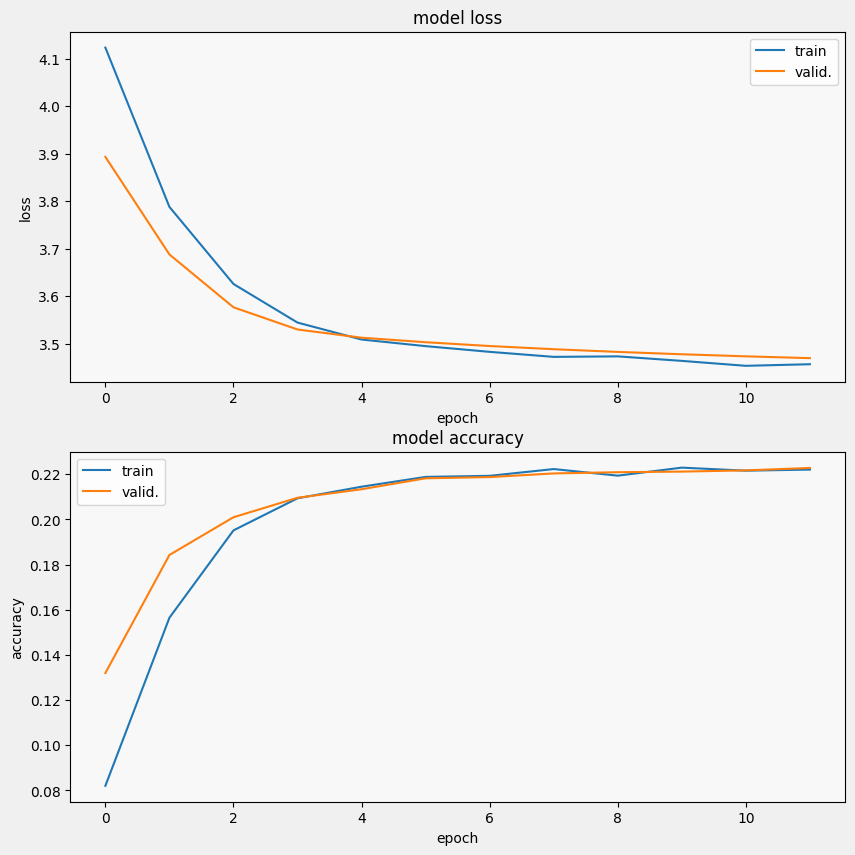

In [16]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Step 7: Evaluate Predictions #

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. We'll look at two common ways of validation: plotting the **confusion matrix** and **visual validation**.

In [17]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Confusion Matrix ##

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows the actual class of an image tabulated against its predicted class. It is one of the best tools you have for evaluating the performance of a classifier.

The following cell does some processing on the validation data and then creates the matrix with the `confusion_matrix` function included in [`scikit-learn`](https://scikit-learn.org/stable/index.html).

In [18]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

I0000 00:00:1756222203.444821      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5596867530805883097


E0000 00:00:1756222203.462981      74 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1_1/dense_1_1/BiasAdd/ReadVariableOp.


I0000 00:00:1756222203.518208     863 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7320526102892703545), session_name()


I0000 00:00:1756222209.559667     863 tpu_compile_op_common.cc:245] Compilation of 7320526102892703545 with session name  took 6.041375536s and succeeded


I0000 00:00:1756222209.561722     863 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7320526102892703545), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_5596867530805883097", property.function_library_fingerprint = 4704291093772383465, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756222209.561747     863 tpu_compilation_cache_interface.cc:542] After adding entry for key 7320526102892703545 with session_name  cache is 3 entries (36898109 bytes),  marked for eviction 0 entries (0 bytes).


      1/Unknown 9s 9s/step

      2/Unknown 11s 1s/step

      3/Unknown 12s 1s/step

      4/Unknown 14s 1s/step

      5/Unknown 15s 1s/step

      6/Unknown 17s 1s/step

      7/Unknown 18s 1s/step

      8/Unknown 20s 1s/step

      9/Unknown 21s 1s/step

     10/Unknown 23s 1s/step

     11/Unknown 24s 1s/step

     12/Unknown 25s 1s/step

     13/Unknown 27s 1s/step

     14/Unknown 28s 1s/step

     15/Unknown 30s 1s/step

     16/Unknown 31s 1s/step

     17/Unknown 33s 1s/step

     18/Unknown 34s 1s/step

     19/Unknown 36s 1s/step

     20/Unknown 37s 1s/step

     21/Unknown 39s 1s/step

     22/Unknown 40s 1s/step

     23/Unknown 41s 1s/step

     24/Unknown 43s 1s/step

     25/Unknown 44s 1s/step

     26/Unknown 45s 1s/step

     27/Unknown 47s 1s/step

     28/Unknown 48s 1s/step

     29/Unknown 50s 1s/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them with a plot of the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


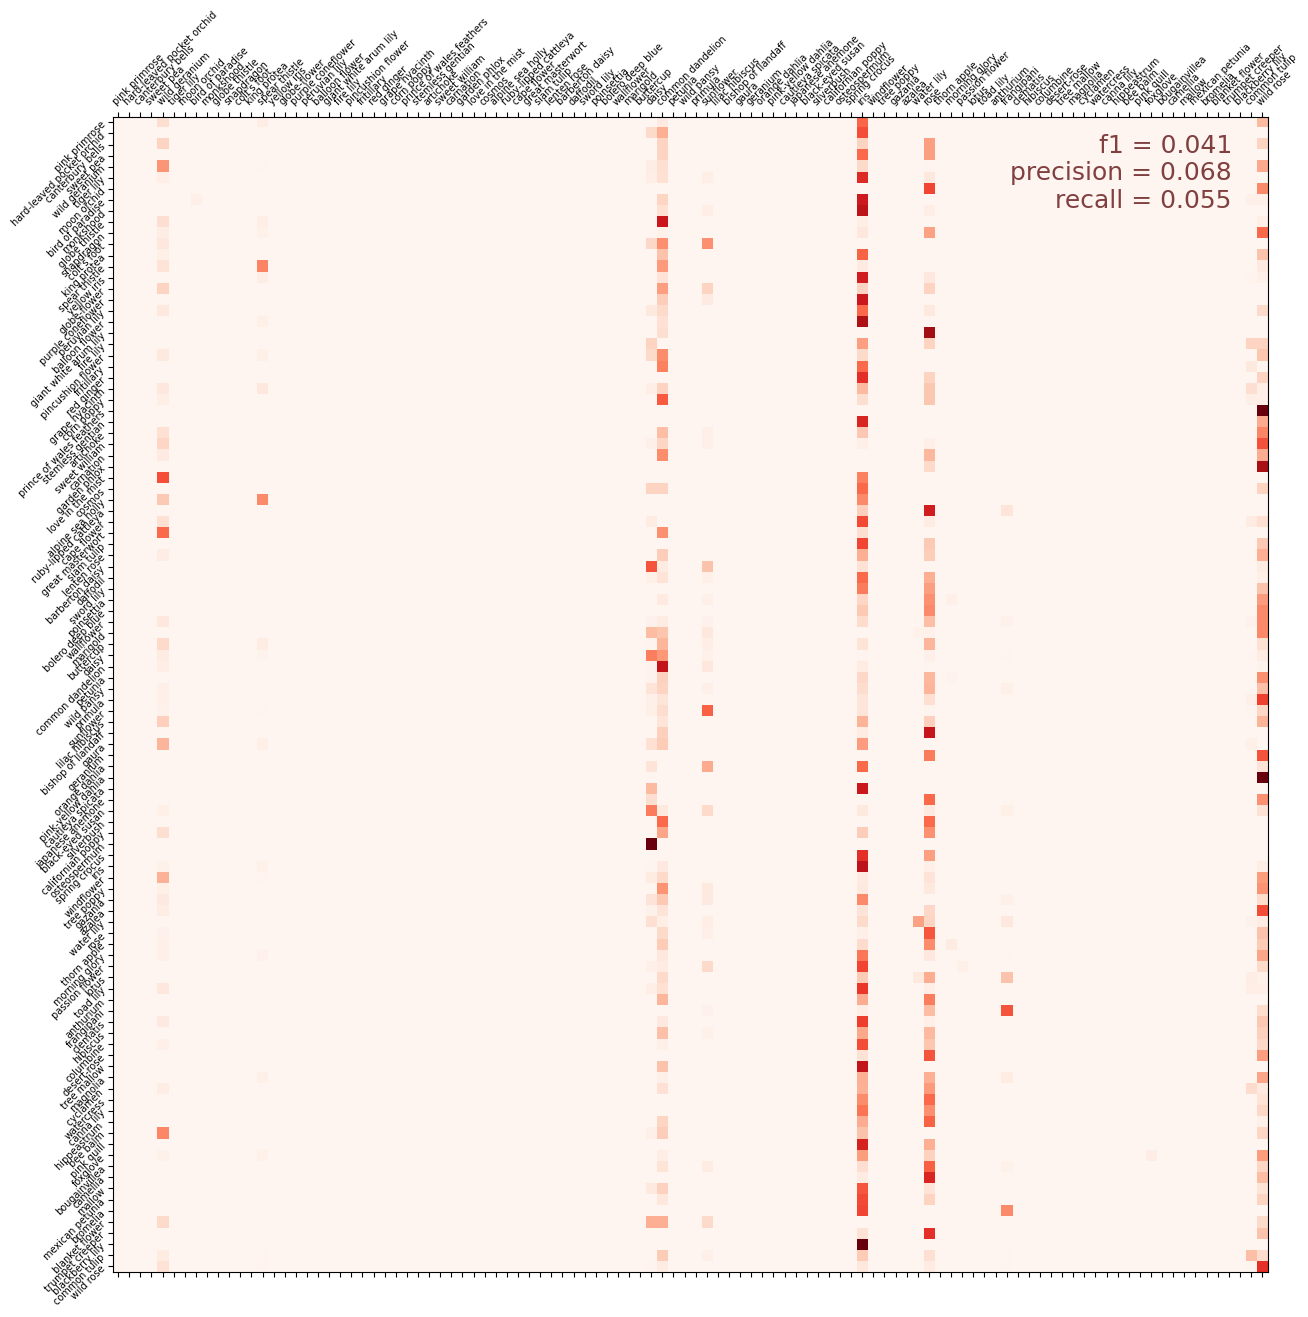

In [19]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images your model has trouble with.

This cell will set up the validation set to display 20 images at a time -- you can change this to display more or fewer, if you like.

In [20]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

And here is a set of flowers with their predicted species. Run the cell again to see another set.

I0000 00:00:1756222254.264971      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11977009887187203739


I0000 00:00:1756222254.423789     891 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4959364322751788259), session_name()


I0000 00:00:1756222263.584958     891 tpu_compile_op_common.cc:245] Compilation of 4959364322751788259 with session name  took 9.161117187s and succeeded


I0000 00:00:1756222263.586539     891 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4959364322751788259), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11977009887187203739", property.function_library_fingerprint = 17576801623902871454, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,512,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756222263.586563     891 tpu_compilation_cache_interface.cc:542] After adding entry for key 4959364322751788259 with session_name  cache is 4 entries (46273086 bytes),  marked for eviction 0 entries (0 bytes).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


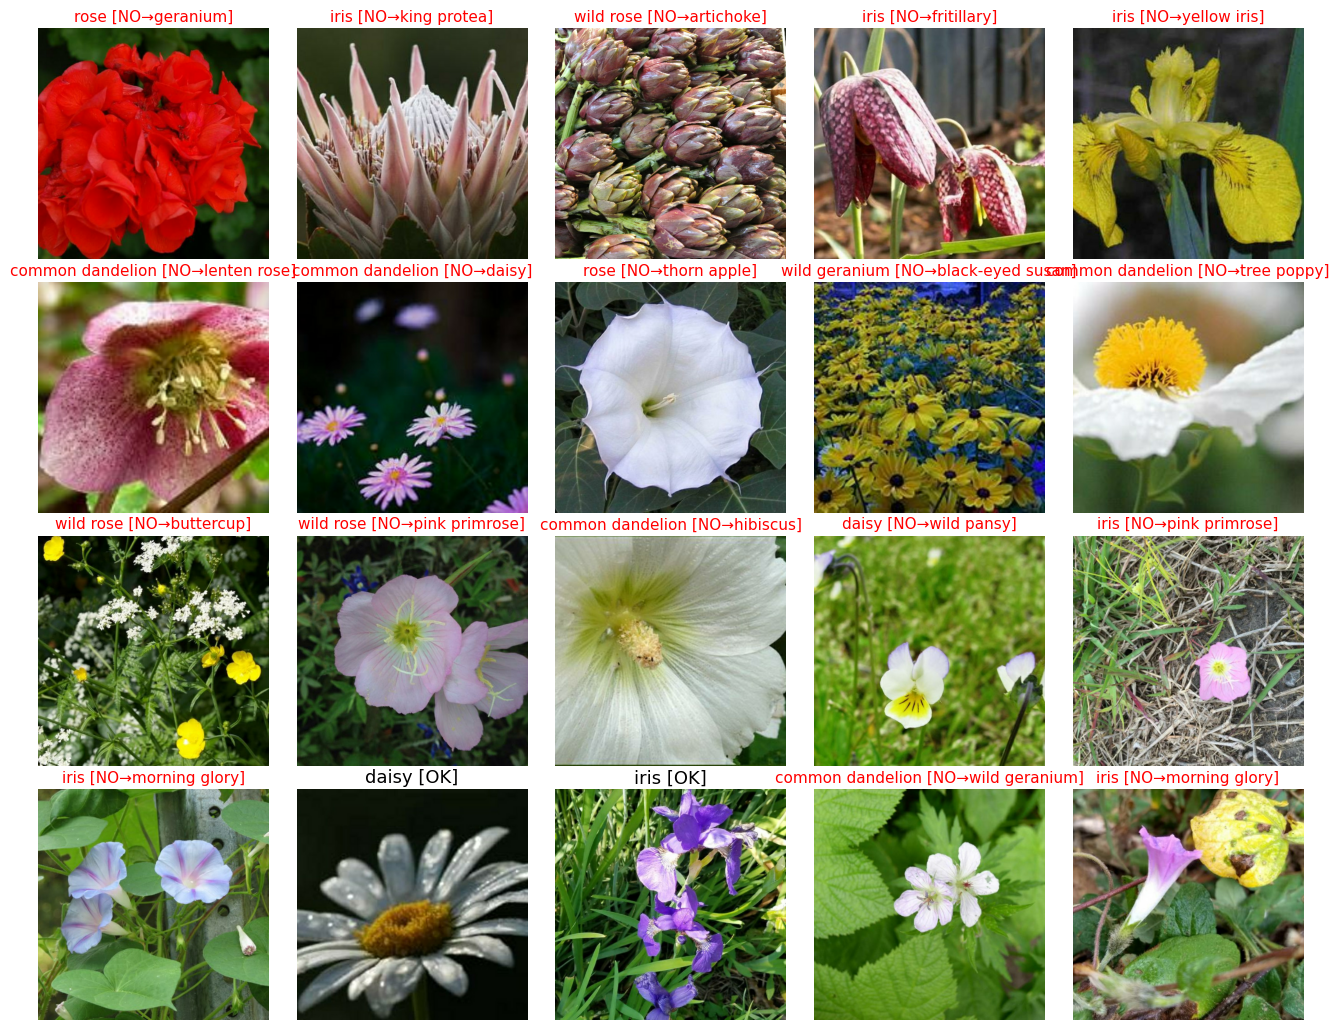

In [21]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 8: Make Test Predictions #

Once you're satisfied with everything, you're ready to make predictions on the test set.

In [22]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


      1/Unknown 3s 3s/step

      2/Unknown 5s 2s/step

      3/Unknown 6s 2s/step

      4/Unknown 8s 2s/step

      5/Unknown 9s 1s/step

      6/Unknown 10s 1s/step

      7/Unknown 12s 1s/step

      8/Unknown 13s 2s/step

      9/Unknown 15s 1s/step

     10/Unknown 16s 2s/step

     11/Unknown 18s 2s/step

     12/Unknown 19s 2s/step

     13/Unknown 21s 2s/step

     14/Unknown 22s 1s/step

     15/Unknown 24s 1s/step

     16/Unknown 25s 1s/step

     17/Unknown 27s 1s/step

     18/Unknown 28s 1s/step

     19/Unknown 30s 1s/step

     20/Unknown 31s 1s/step

     21/Unknown 33s 1s/step

     22/Unknown 34s 1s/step

     23/Unknown 36s 1s/step

     24/Unknown 38s 2s/step

     25/Unknown 39s 2s/step

     26/Unknown 41s 2s/step

     27/Unknown 42s 2s/step

     28/Unknown 44s 2s/step

     29/Unknown 45s 2s/step

     30/Unknown 47s 2s/step

     31/Unknown 48s 2s/step

     32/Unknown 50s 2s/step

     33/Unknown 51s 2s/step

     34/Unknown 53s 2s/step

     35/Unknown 54s 2s/step

     36/Unknown 56s 2s/step

     37/Unknown 57s 2s/step

     38/Unknown 59s 2s/step

     39/Unknown 60s 2s/step

     40/Unknown 62s 2s/step

     41/Unknown 63s 2s/step

     42/Unknown 65s 2s/step

     43/Unknown 66s 2s/step

     44/Unknown 68s 2s/step

     45/Unknown 69s 2s/step

     46/Unknown 71s 2s/step

     47/Unknown 72s 2s/step

     48/Unknown 74s 2s/step

     49/Unknown 75s 2s/step

     50/Unknown 77s 2s/step

     51/Unknown 78s 2s/step

     52/Unknown 80s 2s/step

     53/Unknown 81s 2s/step

     54/Unknown 83s 2s/step

     55/Unknown 84s 2s/step

     56/Unknown 86s 2s/step

     57/Unknown 87s 2s/step

I0000 00:00:1756222355.647282     824 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13982018371365091753), session_name()


I0000 00:00:1756222361.686841     824 tpu_compile_op_common.cc:245] Compilation of 13982018371365091753 with session name  took 6.039455182s and succeeded


I0000 00:00:1756222361.688699     824 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13982018371365091753), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11977009887187203739", property.function_library_fingerprint = 17576801623902871454, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,512,512,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1756222361.688724     824 tpu_compilation_cache_interface.cc:542] After adding entry for key 13982018371365091753 with session_name  cache is 5 entries (57619662 bytes),  marked for eviction 0 entries (0 bytes).


     58/Unknown 95s 2s/step

/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


58/58 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step


[ 49 103 103 ...  49 103  49]


We'll generate a file `submission.csv`. This file is what you'll submit to get your score on the leaderboard.

In [23]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...


id,label
0b9afbdf2,49
c37a6f3e9,103
00e4f514e,103
1c4736dea,4
252d840db,67
dfc9c6a23,103
53cfc6586,49
541c4d41e,73
59d1b6146,67


# Step 9: Make a submission #

If you haven't already, create your own editable copy of this notebook by clicking on the **Copy and Edit** button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161321) to chat with other Learners.*